In [2]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
from iznetwork import IzNetwork

In [3]:
class Neuron:
    def __init__(self, id, neuron_type, module):
        self.id = id
        self.neuron_type = neuron_type
        self.module = module
        self.connections = set()

    def connect(self, other_neuron, connection_matrix, connection_matrix_dict, weights, delays):
        if other_neuron not in self.connections:
            self.connections.add(other_neuron)
            # e_e connection
            if self.neuron_type == 'e' and other_neuron.neuron_type == 'e':
                i, j = connection_matrix_dict[self, other_neuron]
                connection_matrix[i, j] = 1
                weights[i, j] = 1 * 17  # weight is 1, scaling factor is 17
                delays[i, j] = rn.randint(1, 21)

            # e_i connection
            if self.neuron_type == 'e' and other_neuron.neuron_type == 'i':
                i, j = connection_matrix_dict[self, other_neuron]
                connection_matrix[i, j] = 1
                weights[i, j] = rn.uniform(0, 1) * 50
                delays[i, j] = 1
                self.module.available_e_neurons.remove(self)

            # i_e connection
            if self.neuron_type == 'i' and other_neuron.neuron_type == 'e':
                i, j = connection_matrix_dict[self, other_neuron]
                connection_matrix[i, j] = 1
                weights[i, j] = rn.uniform(-1, 0) * 2
                delays[i, j] = 1

            # i_i connection
            if self.neuron_type == 'i' and other_neuron.neuron_type == 'i':
                i, j = connection_matrix_dict[self, other_neuron]
                connection_matrix[i, j] = 1
                weights[i, j] = rn.uniform(-1, 0) * 1
                delays[i, j] = 1

    def disconnect(self, other_neuron, connection_matrix, connection_matrix_dict, weights):
        self.connections.remove(other_neuron)
        i, j = connection_matrix_dict[self, other_neuron]
        connection_matrix[i, j] = 0
        weights[i, j] = 0
        if self.neuron_type == 'e' and other_neuron.neuron_type == 'i':
            self.module.available_e_neurons.append(self)


class Module:
    def __init__(self, module_id, module_type, N, used_ids):
        self.module_id = module_id
        self.neuron_type = module_type
        self.N = N
        self.neurons = []
        self.available_e_neurons = []
        if module_type == 'e':
            # self-defined neuron management
            for i in range(N):
                if len(used_ids) == 0:
                    neuron_id = 0
                    neuron = Neuron(neuron_id, 'e', self)
                    self.neurons.append(neuron)
                    used_ids.append(neuron_id)
                    self.available_e_neurons.append(neuron)
                else:
                    neuron_id = max(used_ids) + 1
                    neuron = Neuron(neuron_id, 'e', self)
                    self.neurons.append(neuron)
                    used_ids.append(neuron_id)
                    self.available_e_neurons.append(neuron)

        elif module_type == 'i':
            # self-defined neuron management
            for i in range(N):
                if len(used_ids) == 0:
                    neuron_id = 0
                    neuron = Neuron(neuron_id, 'i', self)
                    self.neurons.append(neuron)
                    used_ids.append(neuron_id)
                else:
                    neuron_id = max(used_ids) + 1
                    neuron = Neuron(neuron_id, 'i', self)
                    self.neurons.append(neuron)
                    used_ids.append(neuron_id)


class Network:
    def __init__(self, num_e_modules, num_i_modules, num_e_neurons, num_i_neurons,
                 p):
        self.num_e_modules = num_e_modules
        self.num_i_modules = num_i_modules
        self.num_e_neurons = num_e_neurons
        self.num_i_neurons = num_i_neurons
        self.N = num_e_modules * num_e_neurons + num_i_modules * num_i_neurons
        self.p = p  # rewiring probability
        self.modules = []  # store all modules
        self.all_neurons = []  # store all neurons
        self.used_ids = []  # all the ids for neurons
        self.connection_matrix = np.zeros((self.N, self.N))
        self.connection_matrix_dict = {}
        ############# using the iznetwork class
        self.i_network = IzNetwork(self.N, 20)
        self.weights = np.zeros((self.N, self.N))
        self.a = np.zeros(self.N)
        self.b = np.zeros(self.N)
        self.c = np.zeros(self.N)
        self.d = np.zeros(self.N)
        self.delays = np.ones((self.N, self.N), dtype=int)
        self.r_e = rn.rand(800)
        self.r_i = rn.rand(200)

        # create excitatory modules
        for i in range(num_e_modules):
            module = Module(f"e_{i}", 'e', num_e_neurons, self.used_ids)
            self.modules.append(module)
            self.all_neurons += module.neurons
        # create inhibitory modules
        for i in range(num_i_modules):
            module = Module(f"i_{i}", 'i', num_i_neurons, self.used_ids)
            self.modules.append(module)
            self.all_neurons += module.neurons

        for i in range(self.N):
            src = self.all_neurons[i]
            if src.neuron_type == "e":
                self.a[i] = 0.02
                self.b[i] = 0.2
                self.c[i] = -65 + 15 * (self.r_e[i] ** 2)
                self.d[i] = 8 - 6 * (self.r_e[i]** 2)

            elif src.neuron_type == "i":
                self.a[i] = 0.02 + 0.08 * self.r_i[i-800]
                self.b[i] = 0.25 - 0.05 * self.r_i[i-800]
                self.c[i] = -65
                self.d[i] = 2

            for j in range(self.N):
                tar = self.all_neurons[j]
                self.connection_matrix_dict[src, tar] = [i, j]
                self.connection_matrix_dict[i, j] = [src, tar]

    def initial_setup(self):
        #  (modular small world -> excitatory to excitatory) 1000 random one-way intra-module connections for each excitatory module
        for module in self.modules:
            if module.neuron_type == 'e':
                src_neurons = module.neurons
                for i in range(1000):
                    src = rn.choice(np.array(src_neurons))
                    remained_neurons = src_neurons.copy()
                    remained_neurons.remove(src)
                    tar = rn.choice(np.array(remained_neurons))  # can't connect to itself
                    src.connect(tar, self.connection_matrix, self.connection_matrix_dict, self.weights, self.delays)

        # Excitatory to inhibitory connections & inhibitary to all neurons
        e_modules = [module for module in self.modules if module.neuron_type == 'e']
        for module in self.modules:
            if module.neuron_type == 'i':
                for i_neuron in module.neurons:
                    # Excitatory to inhibitory connections
                    e_module = rn.choice(np.array(e_modules))
                    while len(e_module.available_e_neurons) < 4:
                        e_module = rn.choice(np.array(e_modules))
                    for i in range(4):
                        e_neuron = rn.choice(e_module.available_e_neurons)
                        e_neuron.connect(i_neuron, self.connection_matrix, self.connection_matrix_dict, self.weights,
                                         self.delays)
                    # Inhibitory to all connections
                    self.all_neurons_cpy = self.all_neurons.copy()
                    self.all_neurons_cpy.remove(i_neuron)
                    for neuron in self.all_neurons_cpy:
                        i_neuron.connect(neuron, self.connection_matrix, self.connection_matrix_dict, self.weights,
                                         self.delays)

    def rewiring(self):
        for module in self.modules:
            if module.neuron_type == 'e':
                for src in module.neurons:
                    same_module_tars = [tar for tar in src.connections if tar.module == src.module]
                    e_neurons_in_other_modules = [item for item in self.all_neurons if
                                                  item not in src.connections and item.neuron_type == 'e' and item.module != src.module]
                    for tar in same_module_tars:
                        if rn.random() < self.p:
                            src.disconnect(tar, self.connection_matrix, self.connection_matrix_dict, self.weights)
                            h = rn.choice(e_neurons_in_other_modules)
                            src.connect(h, self.connection_matrix, self.connection_matrix_dict, self.weights,
                                        self.delays)

    def configure_iznetwork(self):
        self.i_network.setWeights(self.weights)
        self.i_network.setDelays(self.delays)
        self.i_network.setParameters(a=self.a, b=self.b, c=self.c, d=self.d)

In [4]:
def connection_matrix_plot(network, p):
    source, target = np.where(network.connection_matrix == 1)  # Get indices where connection exists
    # #     Plot the connection matrix
    plt.figure(figsize=(6, 6), dpi=300)
    plt.scatter(source, target, color='black', s=1)  # Scatter plot with small dots for connections
    plt.xlabel("Source Neuron")
    plt.ylabel("Target Neuron")
    plt.title(f"Connectivity Matrix for P = {p}")
    plt.savefig(f'c_m_{p}.png', dpi=300)

def raster_plot(V, p):
    V_e = V[:, :800]
    t, n = np.where(V_e > 29)
    plt.figure(figsize=(20, 5), dpi=300)
    plt.scatter(t, n, color='b')
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron index')
    plt.title(f"Raster plot for P = {p}")
    plt.savefig(f'raster_plot_{p}.png', dpi=300)

def mean_firing_plot(V, p, window_size=50, shift_size=20):
    V_e = V[:, :800]

    plt.figure(figsize=(20, 5), dpi=300)
    for i in range(8):
        module_V = V_e[:, i * 100:(i + 1) * 100]

        # Downsample the firing rates by calculating the mean number of spikes in 50ms windows
        firing_rate = []
        for start in range(0, T, shift_size):
            end = start + window_size
            if end < T:
                module_tmp = module_V[start:end]
                number_spikes = len(module_tmp[module_tmp > 29])
                firing_rate.append(number_spikes / (end - start))  # Average spikes in the window
            else:
                module_tmp = module_V[start:T]
                number_spikes = len(module_tmp[module_tmp > 29])
                firing_rate.append(number_spikes / (T - start))

        # Convert firing rate list to numpy array
        firing_rate = np.array(firing_rate)

        plt.plot(np.arange(0, T, 20), firing_rate, label=f'Module {i + 1}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Mean Firing Rate')
    plt.legend()
    plt.title(f"Mean Firing Rate for P = {p}")
    plt.savefig(f'mean_firing_{p}.png', dpi=300)

In [5]:
T = 1000
lambda_rate = 0.01  # Poisson rate
extra_current = 15  # Extra current injected if Poisson event occurs
window_size = 50
shift_size = 20
num_e_modules = 8
num_e_neurons = 100
num_i_modules = 1
num_i_neurons = 200

### P = 0

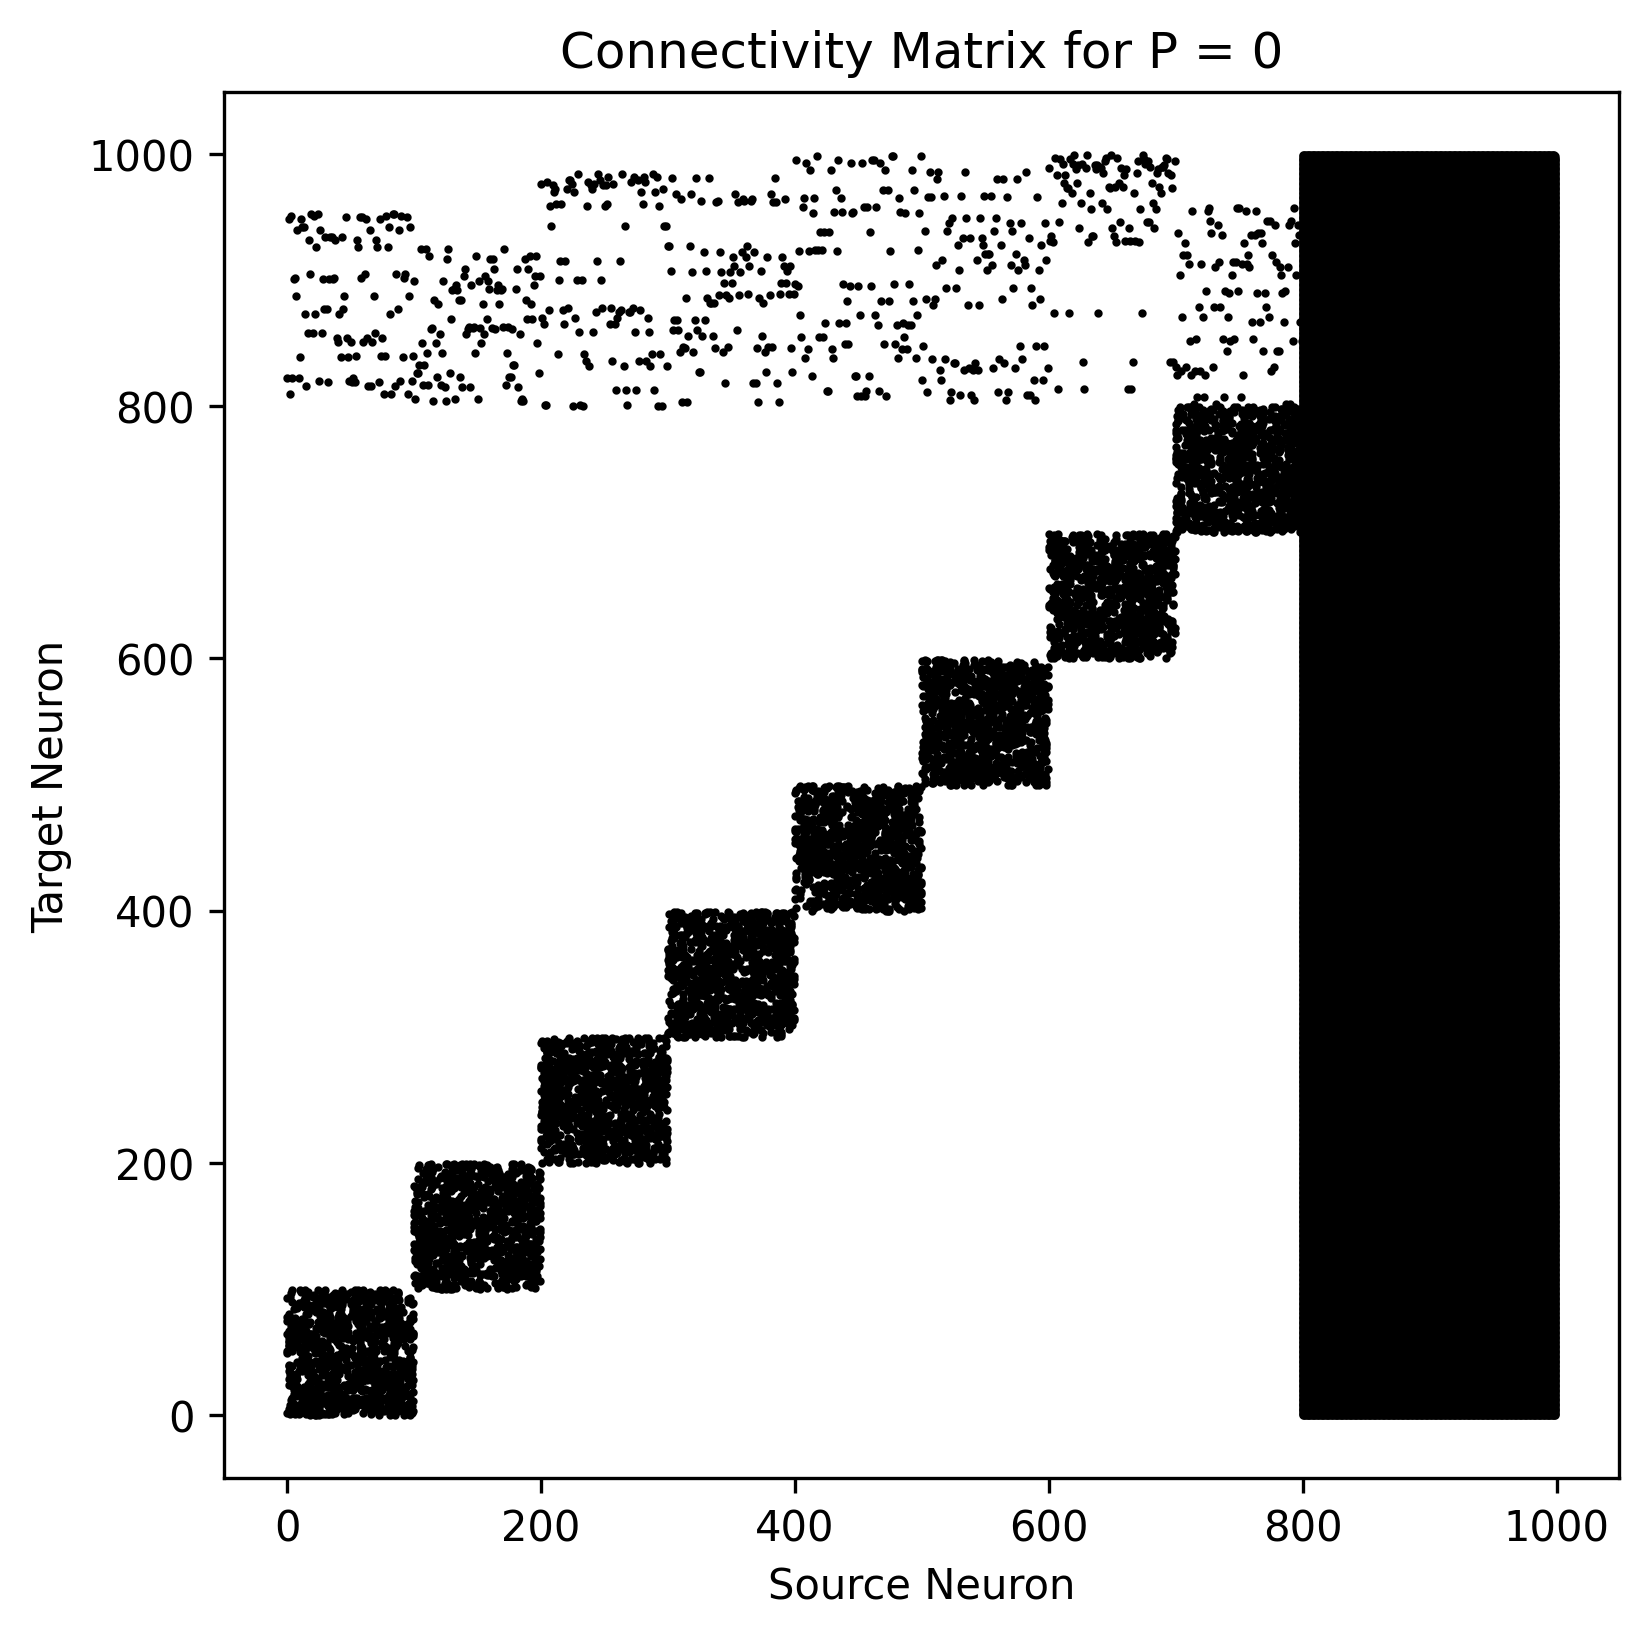

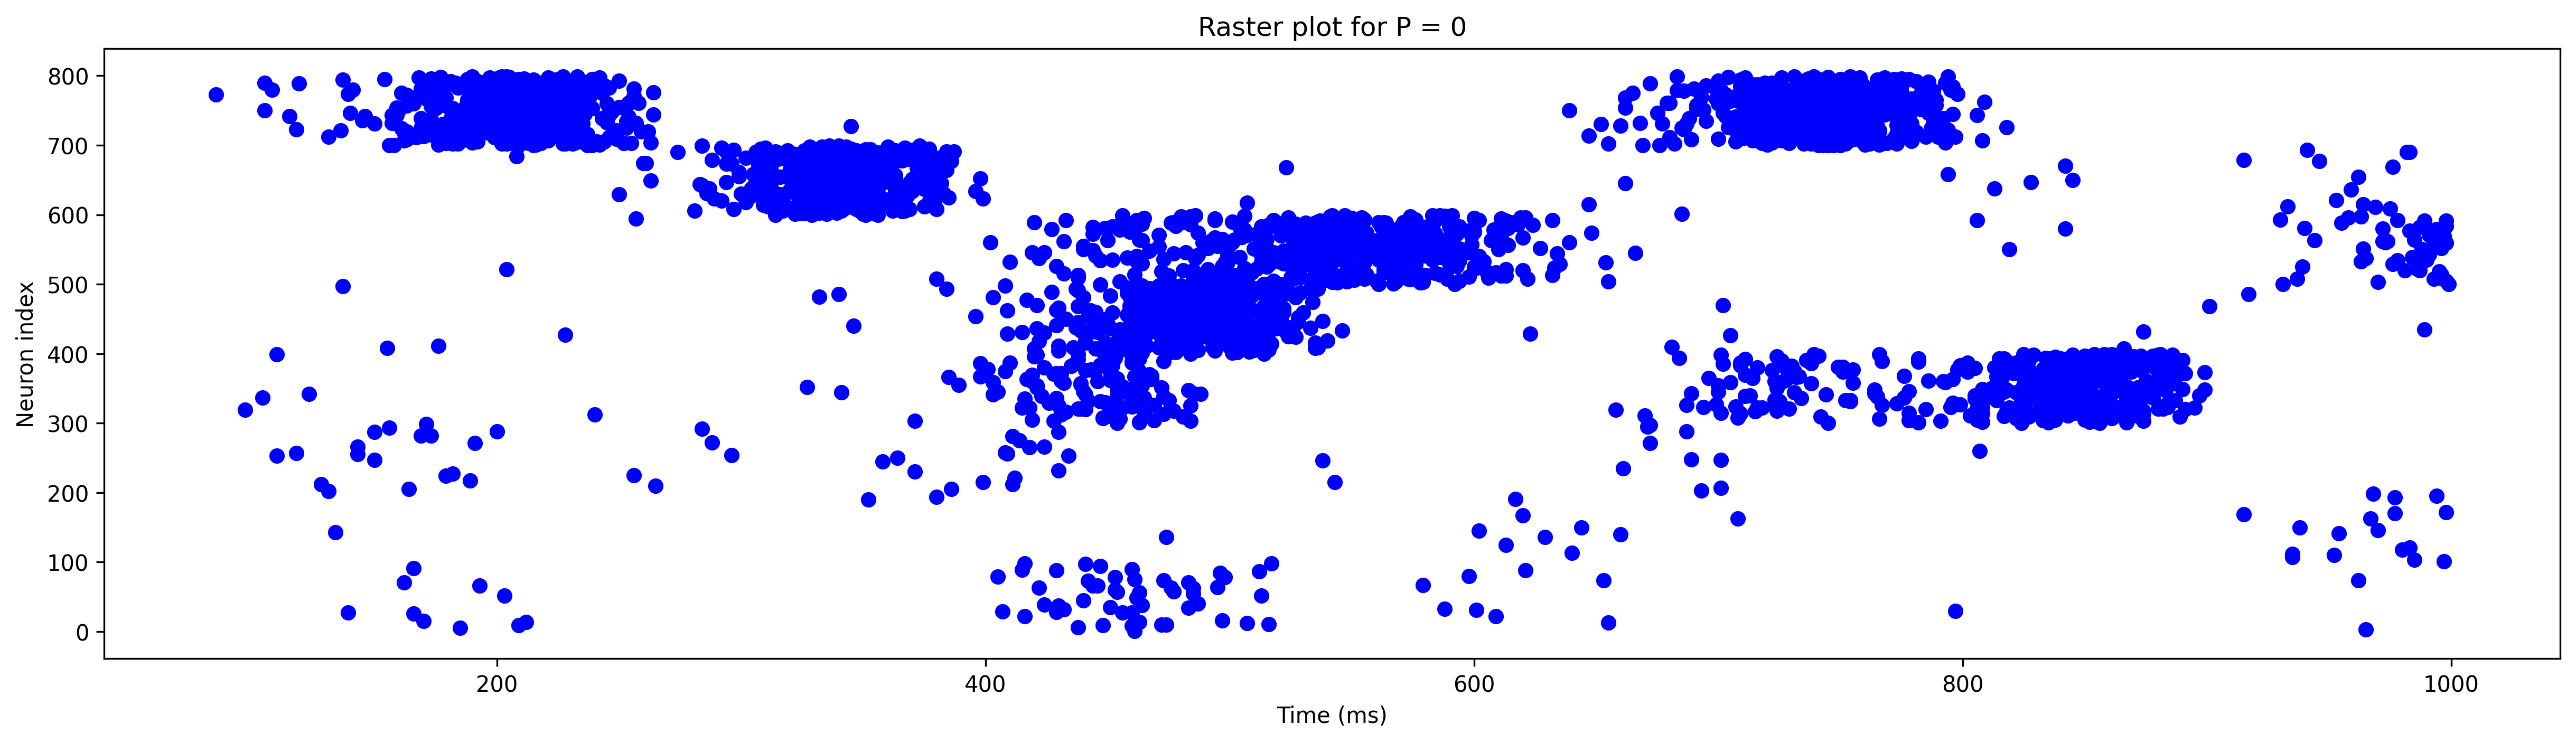

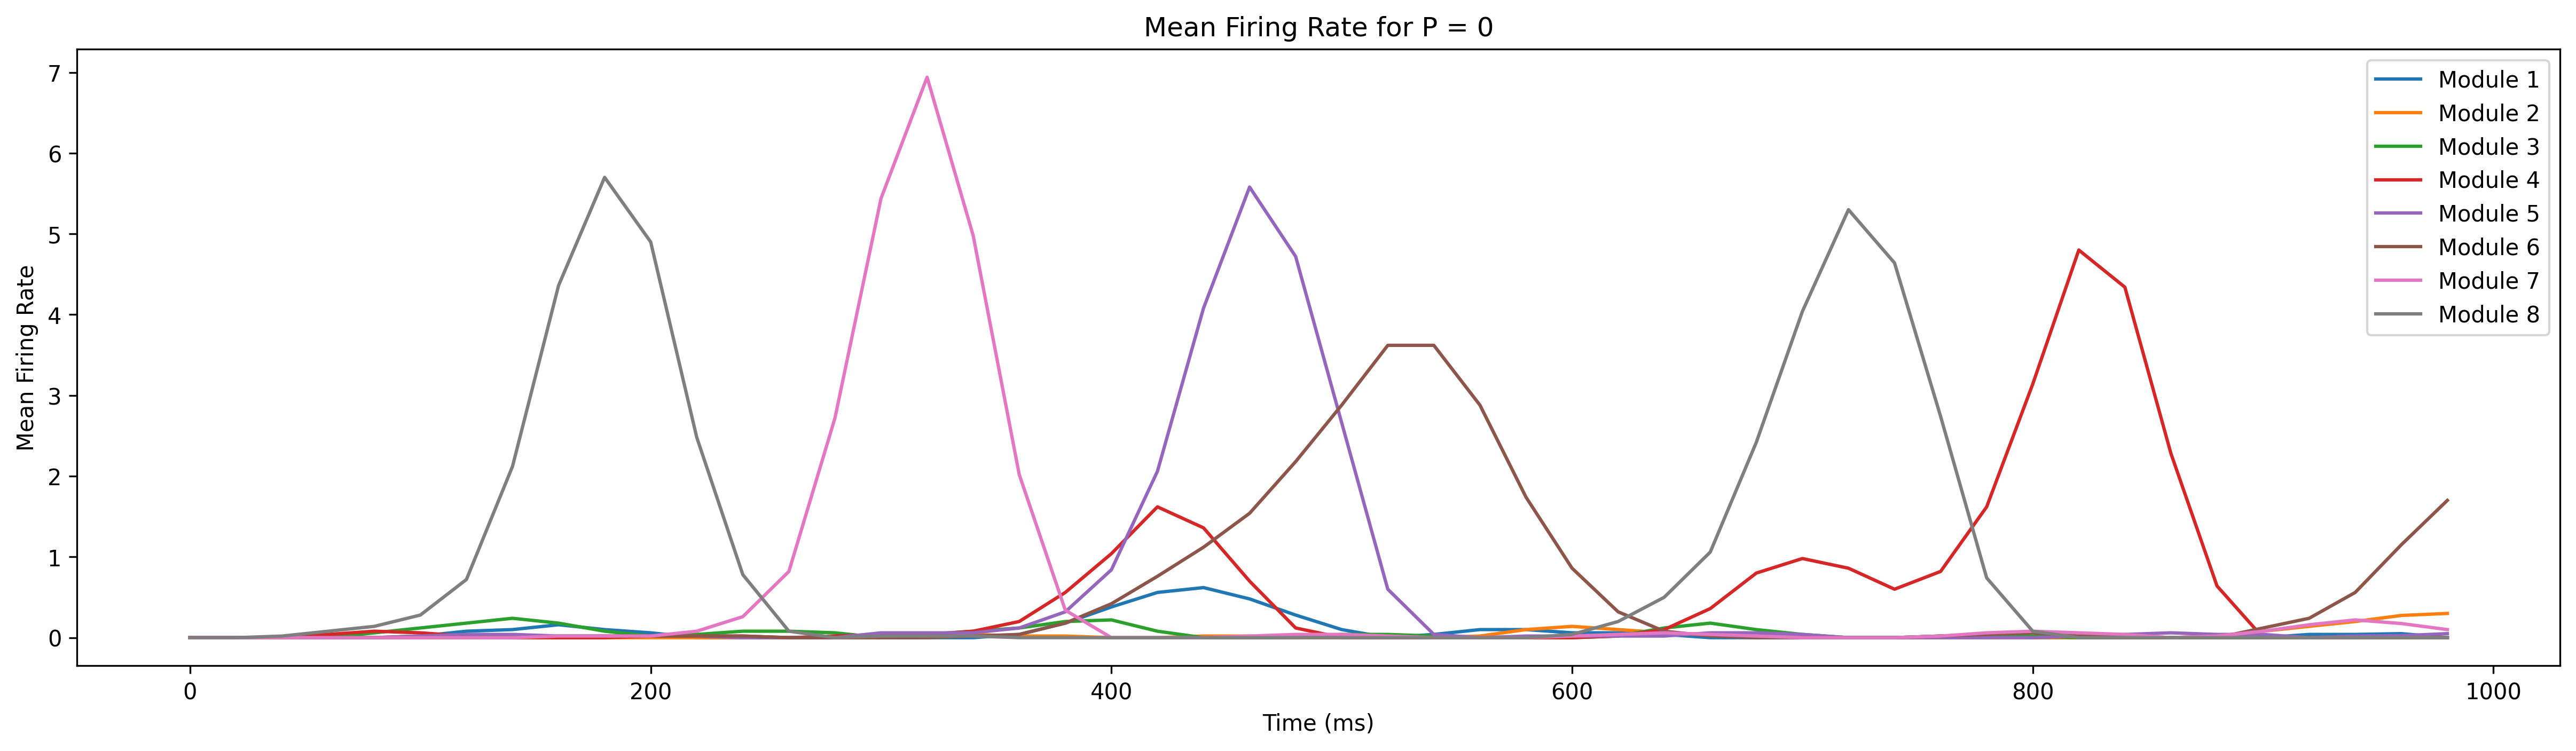

In [6]:
p = 0
network = Network(num_e_modules, num_i_modules, num_e_neurons, num_i_neurons, p)
network.initial_setup()
network.rewiring()
network.configure_iznetwork()
V = np.zeros((T, network.N))
current = np.zeros((T, network.N))  # Initialize current for each neuron (assuming an array of currents for each time step)
# Simulate background firing for each neuron at each time step
for t in range(T):
    poisson_events = np.random.poisson(lambda_rate, network.N)
    current[t, poisson_events > 0] = extra_current
    network.i_network.setCurrent(current[t])
    network.i_network.update()
    V[t, :], _ = network.i_network.getState()

connection_matrix_plot(network, p)
raster_plot(V, p)
mean_firing_plot(V, p)

### P = 0.1

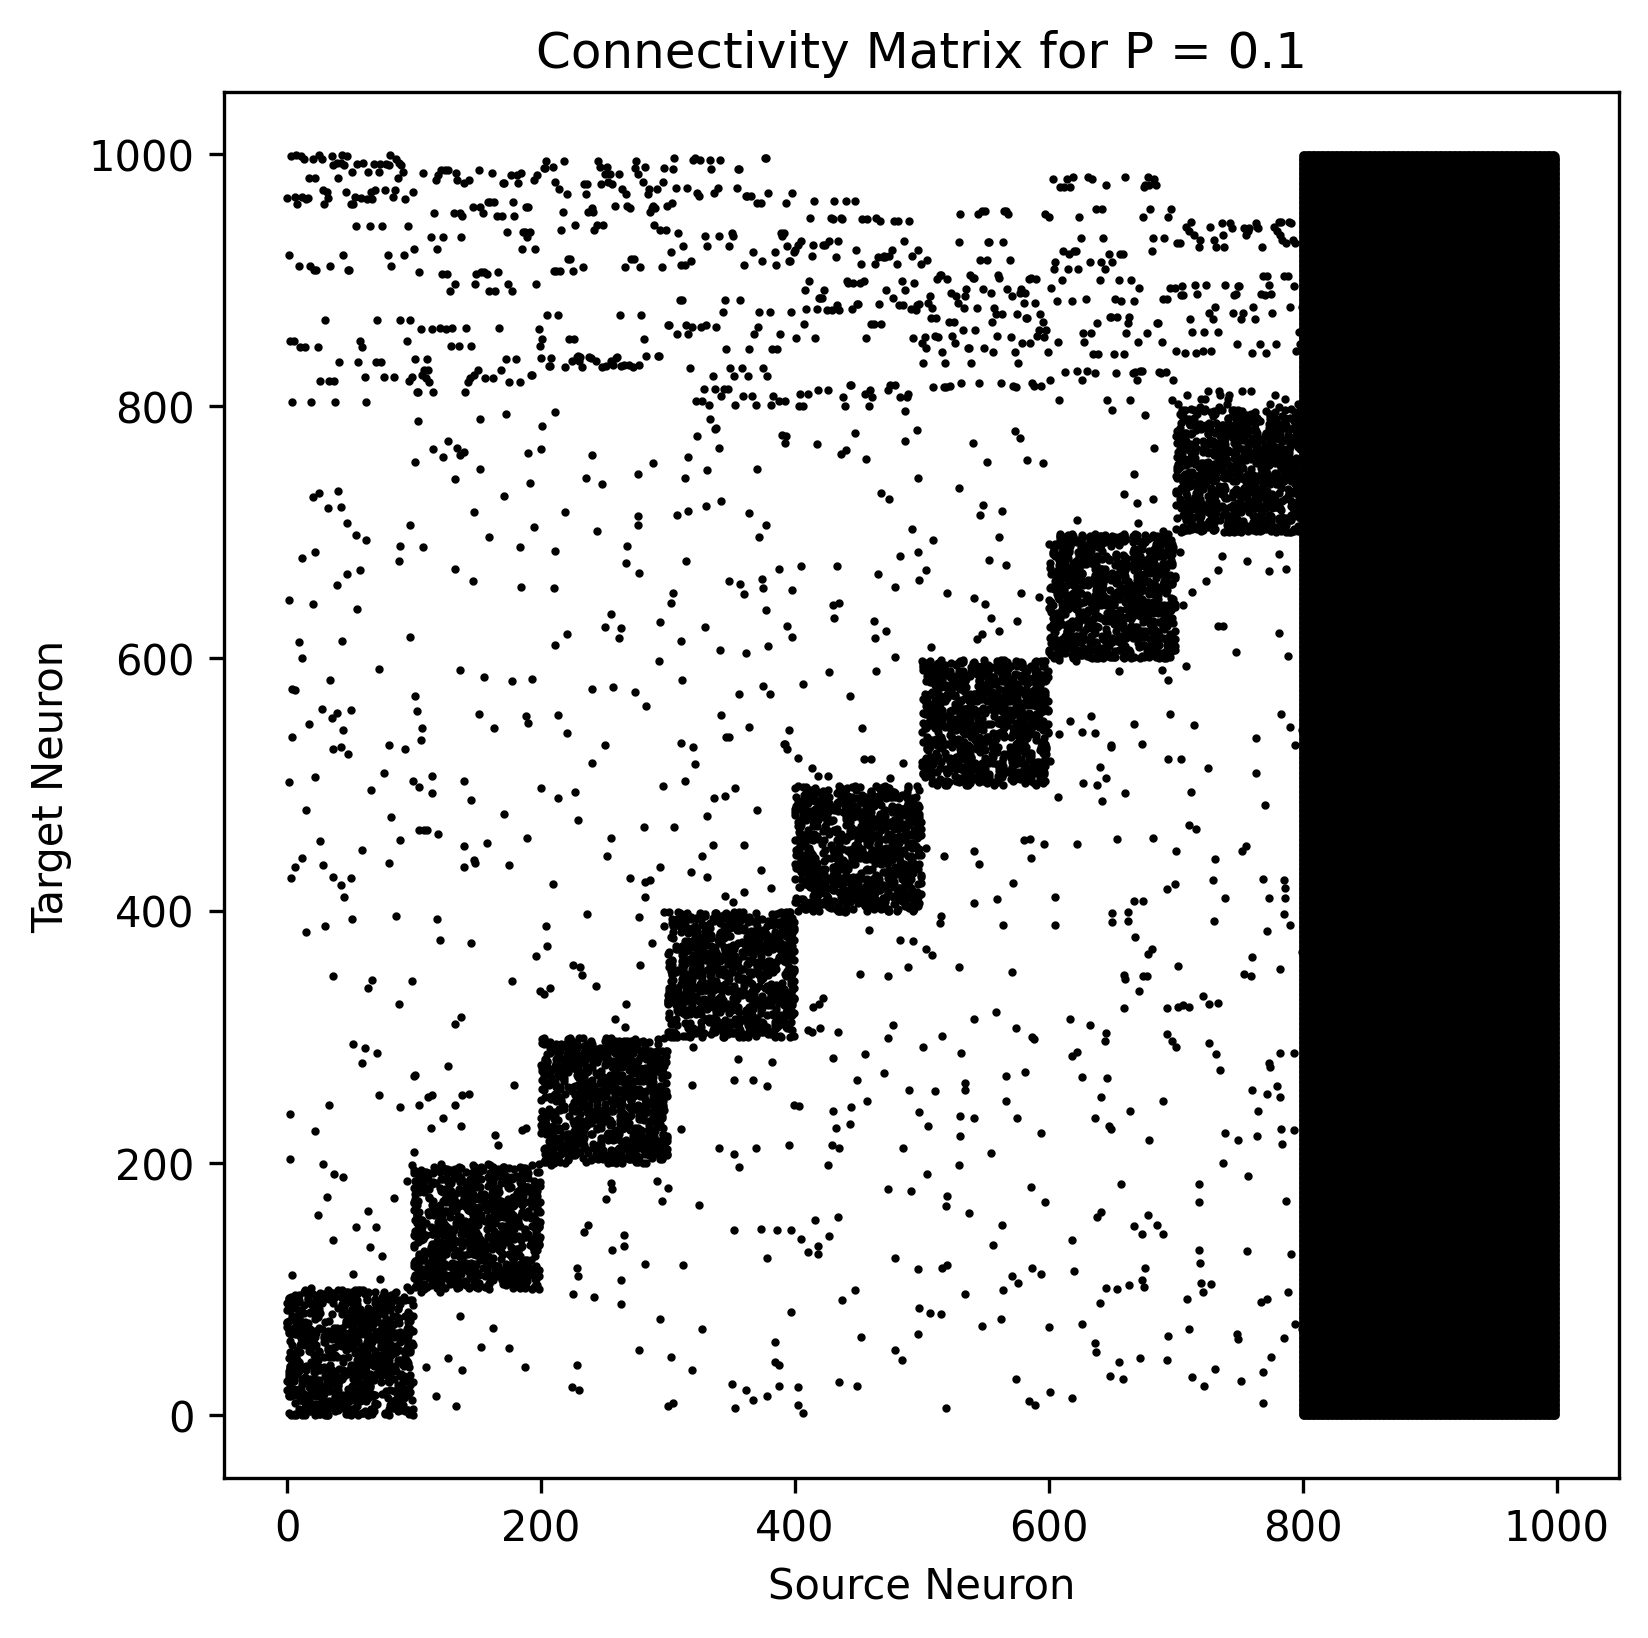

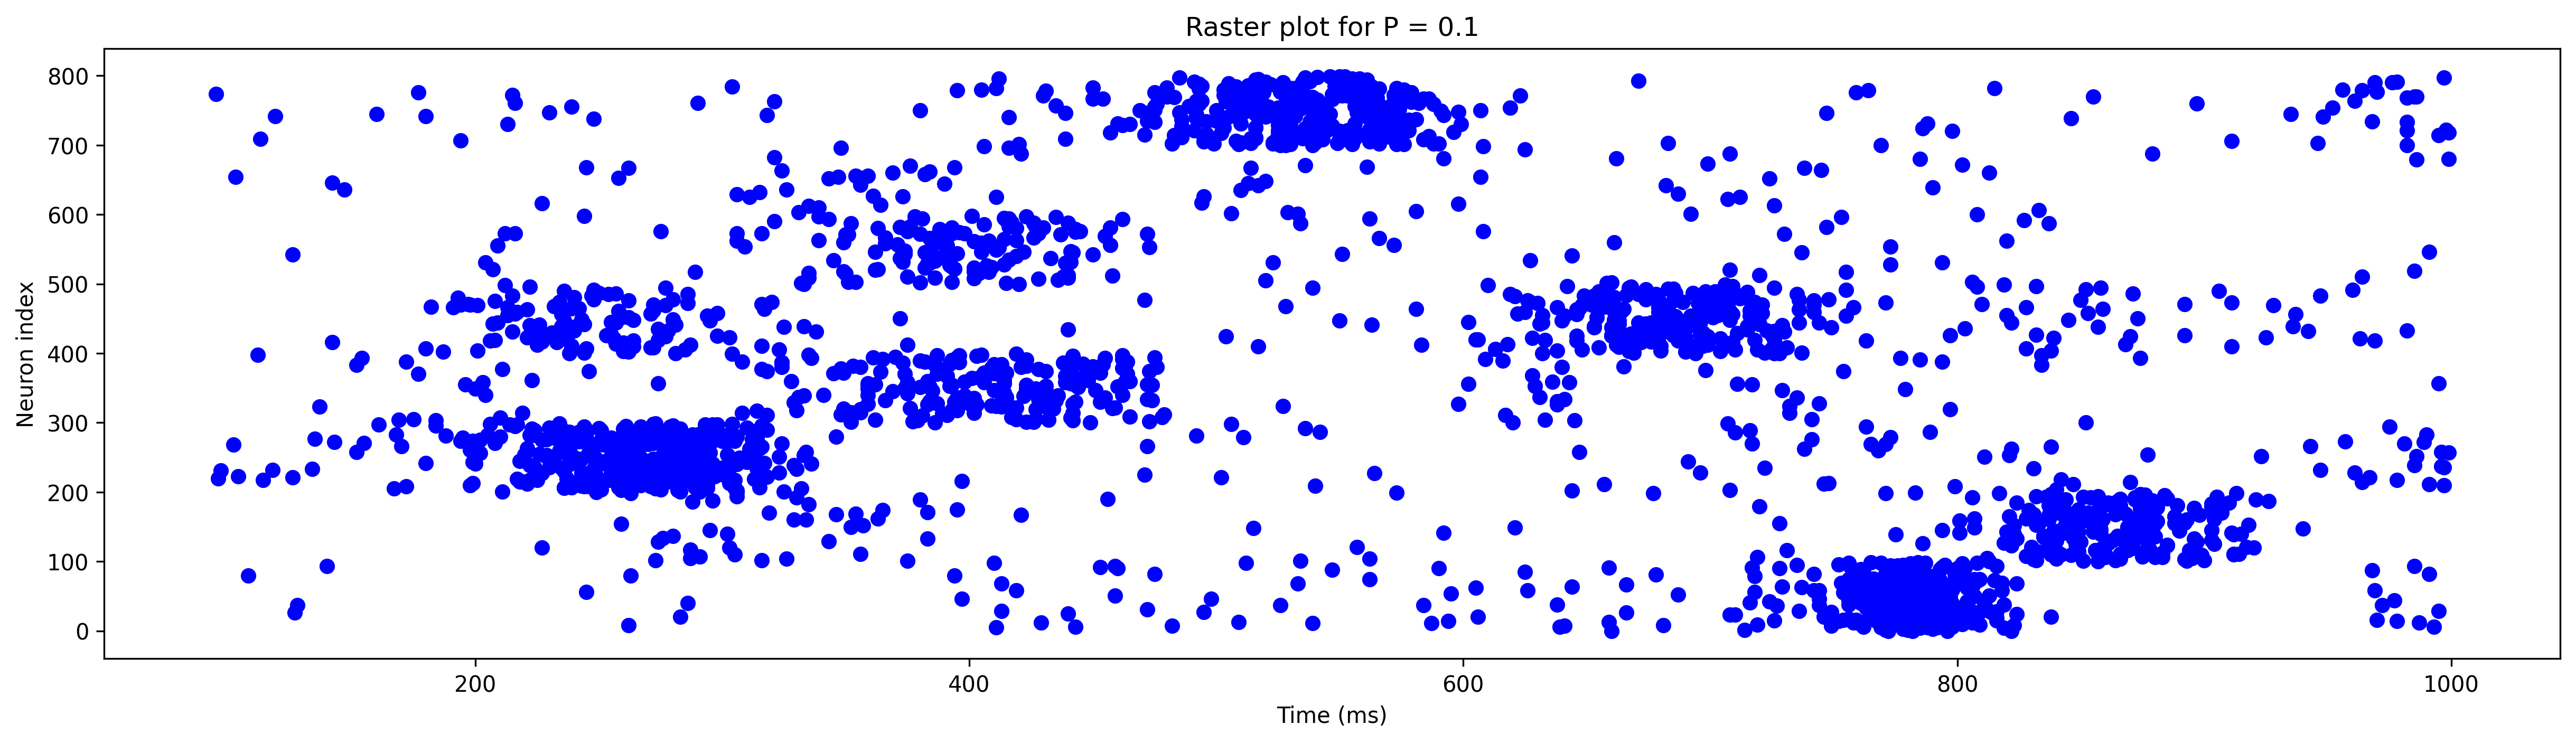

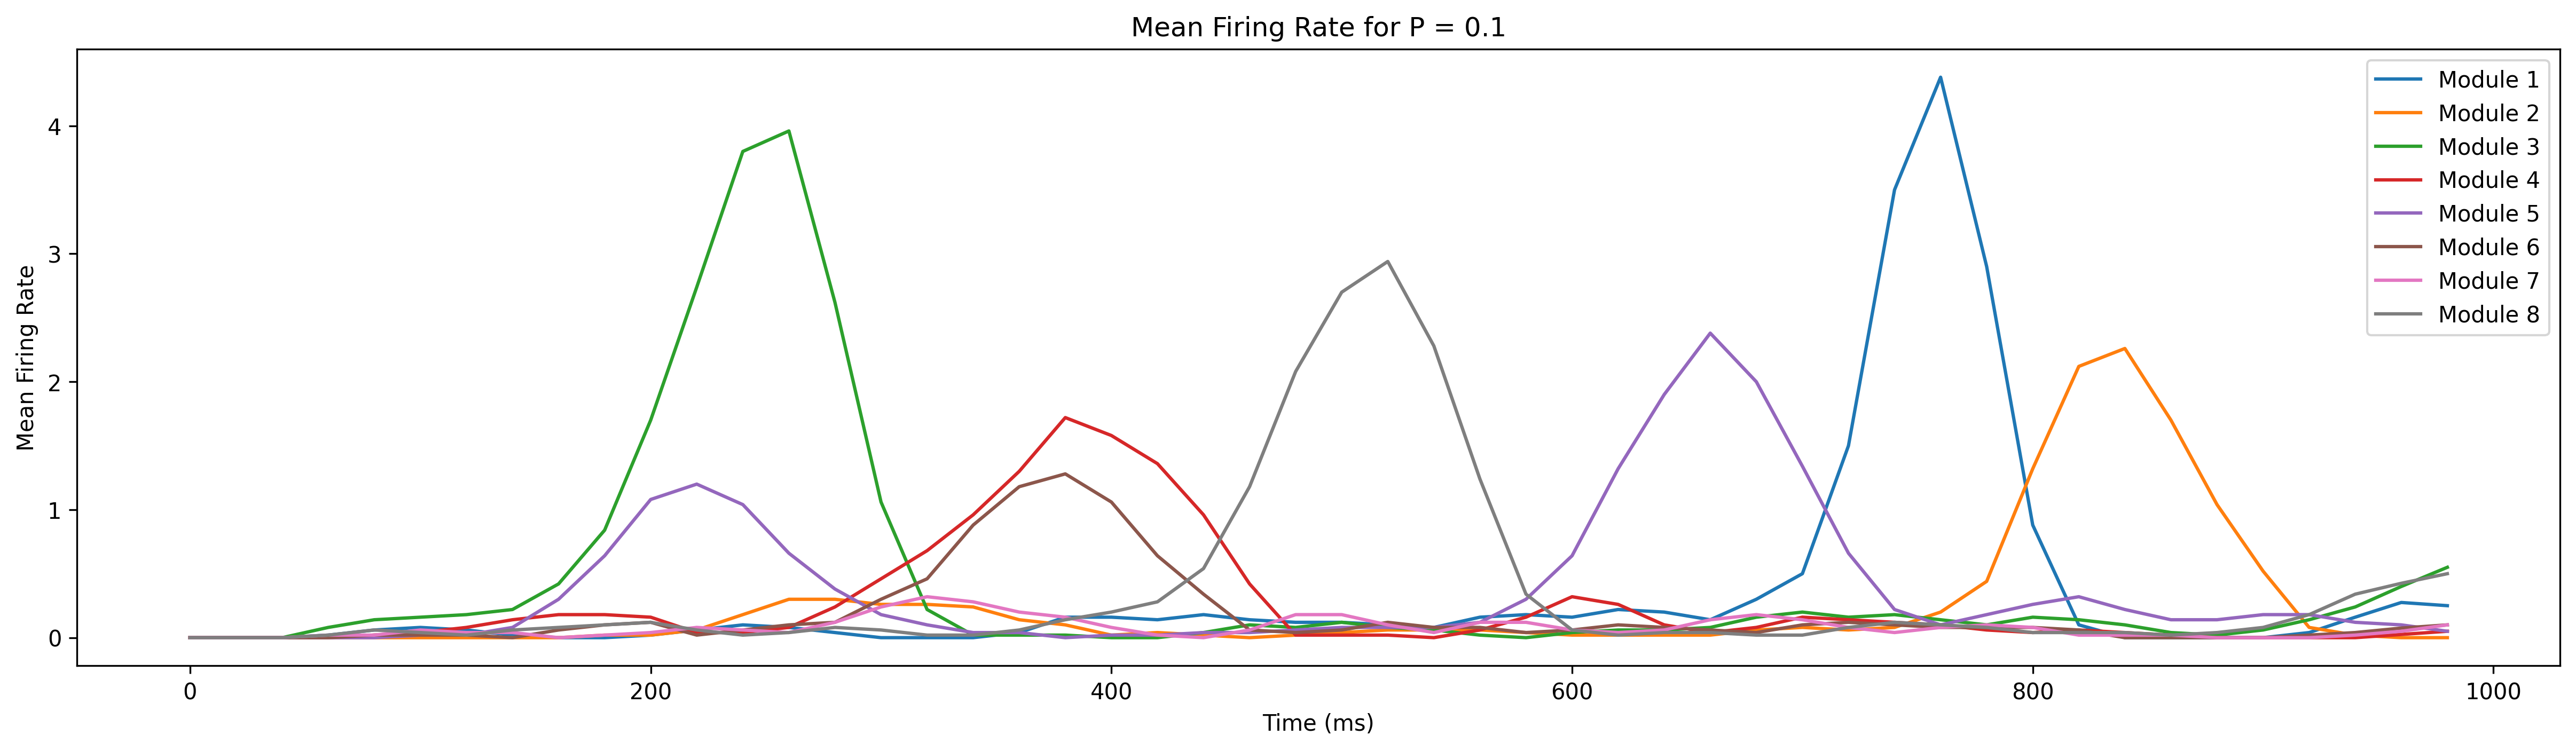

In [7]:
p = 0.1
network = Network(num_e_modules, num_i_modules, num_e_neurons, num_i_neurons, p)
network.initial_setup()
network.rewiring()
network.configure_iznetwork()
V = np.zeros((T, network.N))
current = np.zeros((T, network.N))  # Initialize current for each neuron (assuming an array of currents for each time step)
# Simulate background firing for each neuron at each time step
for t in range(T):
    poisson_events = np.random.poisson(lambda_rate, network.N)
    current[t, poisson_events > 0] = extra_current
    network.i_network.setCurrent(current[t])
    network.i_network.update()
    V[t, :], _ = network.i_network.getState()

connection_matrix_plot(network, p)
raster_plot(V, p)
mean_firing_plot(V, p)

### P = 0.2

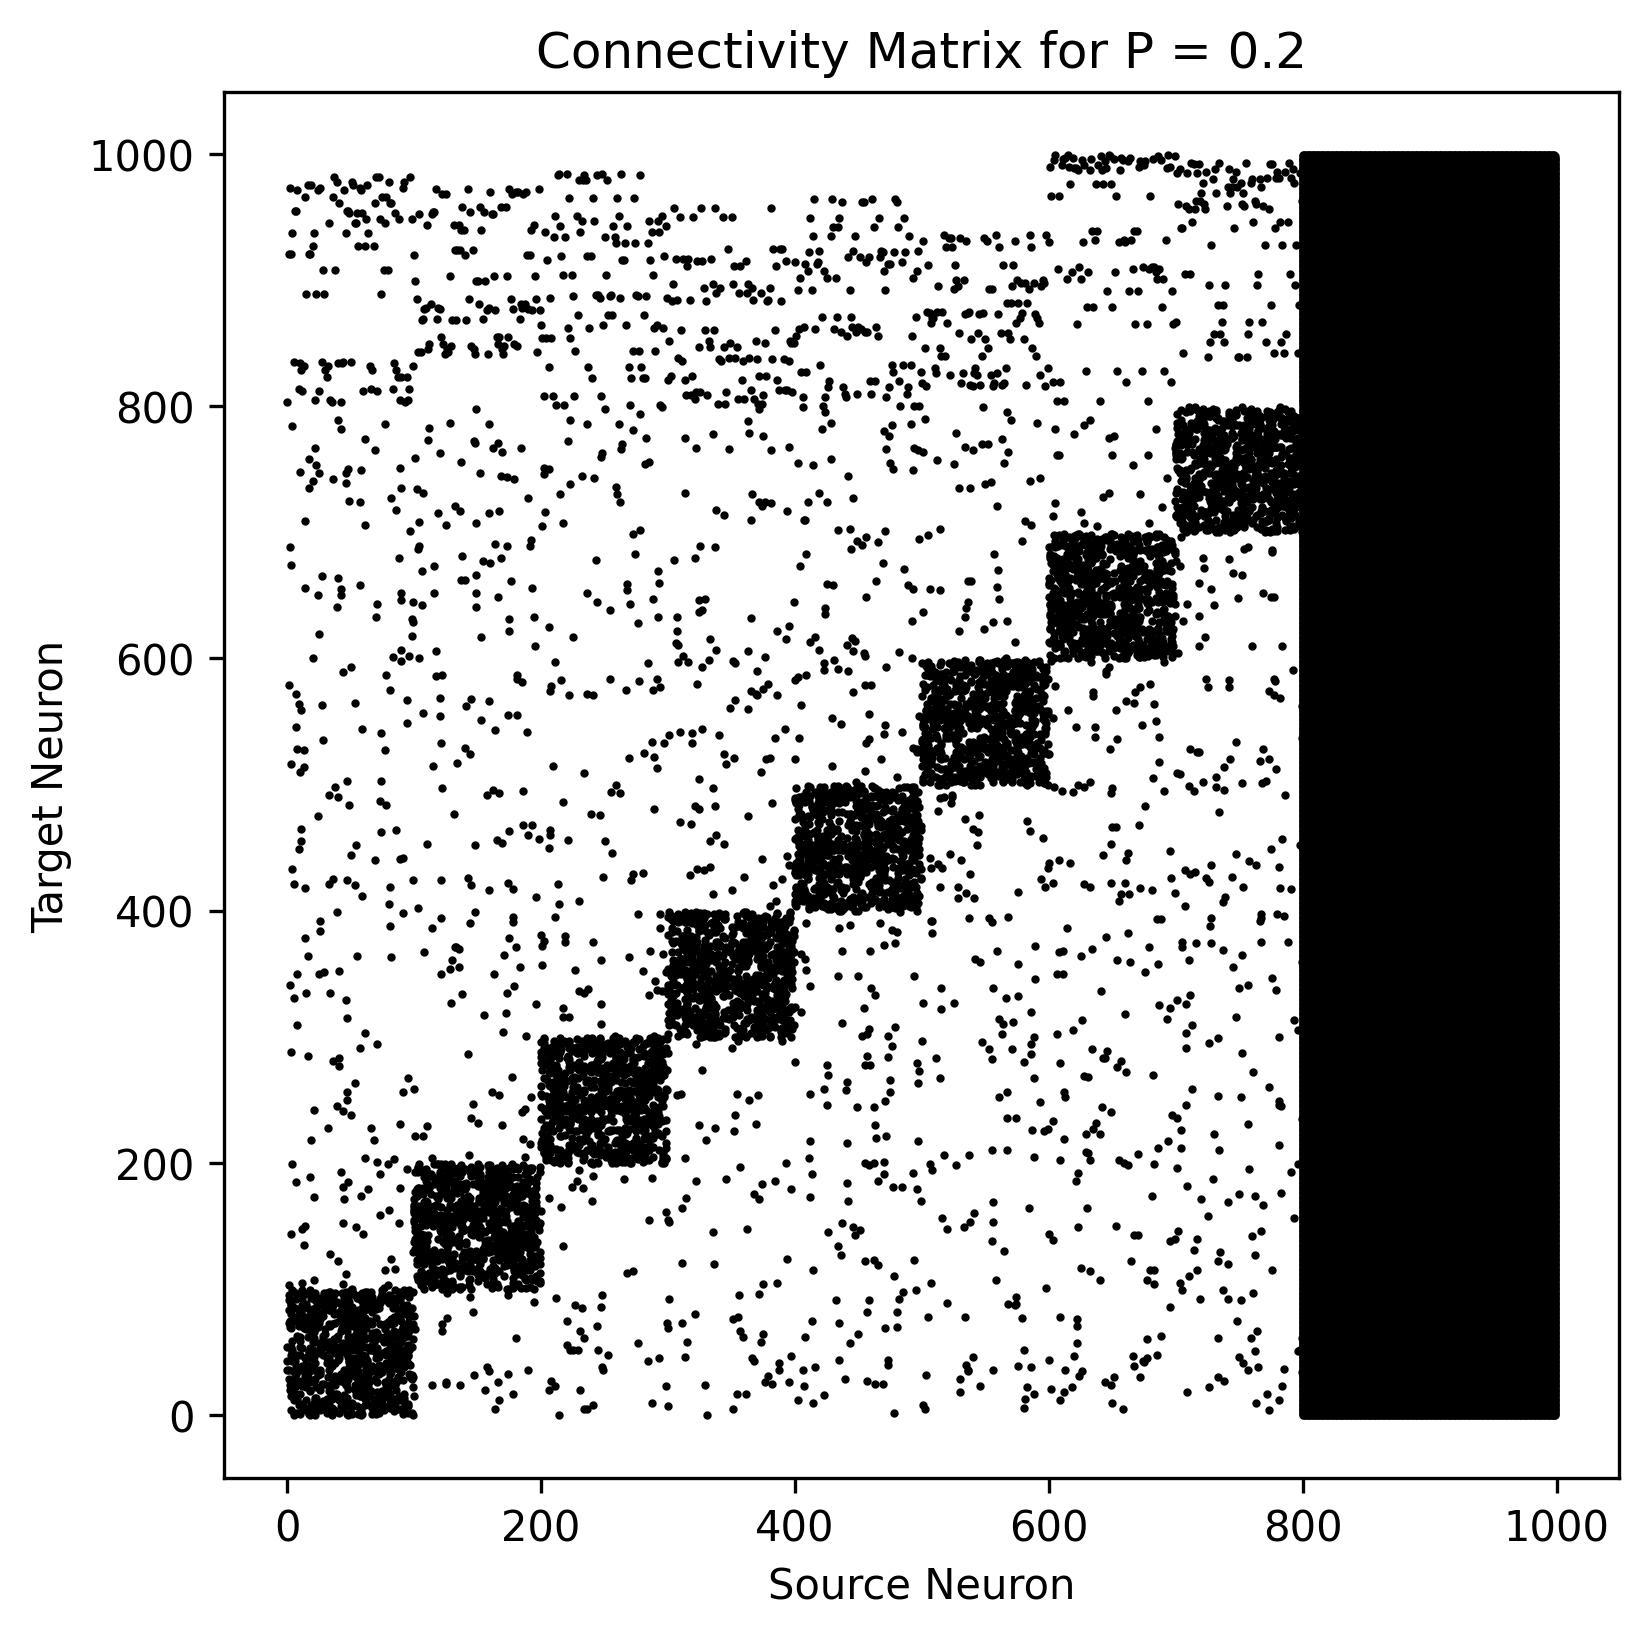

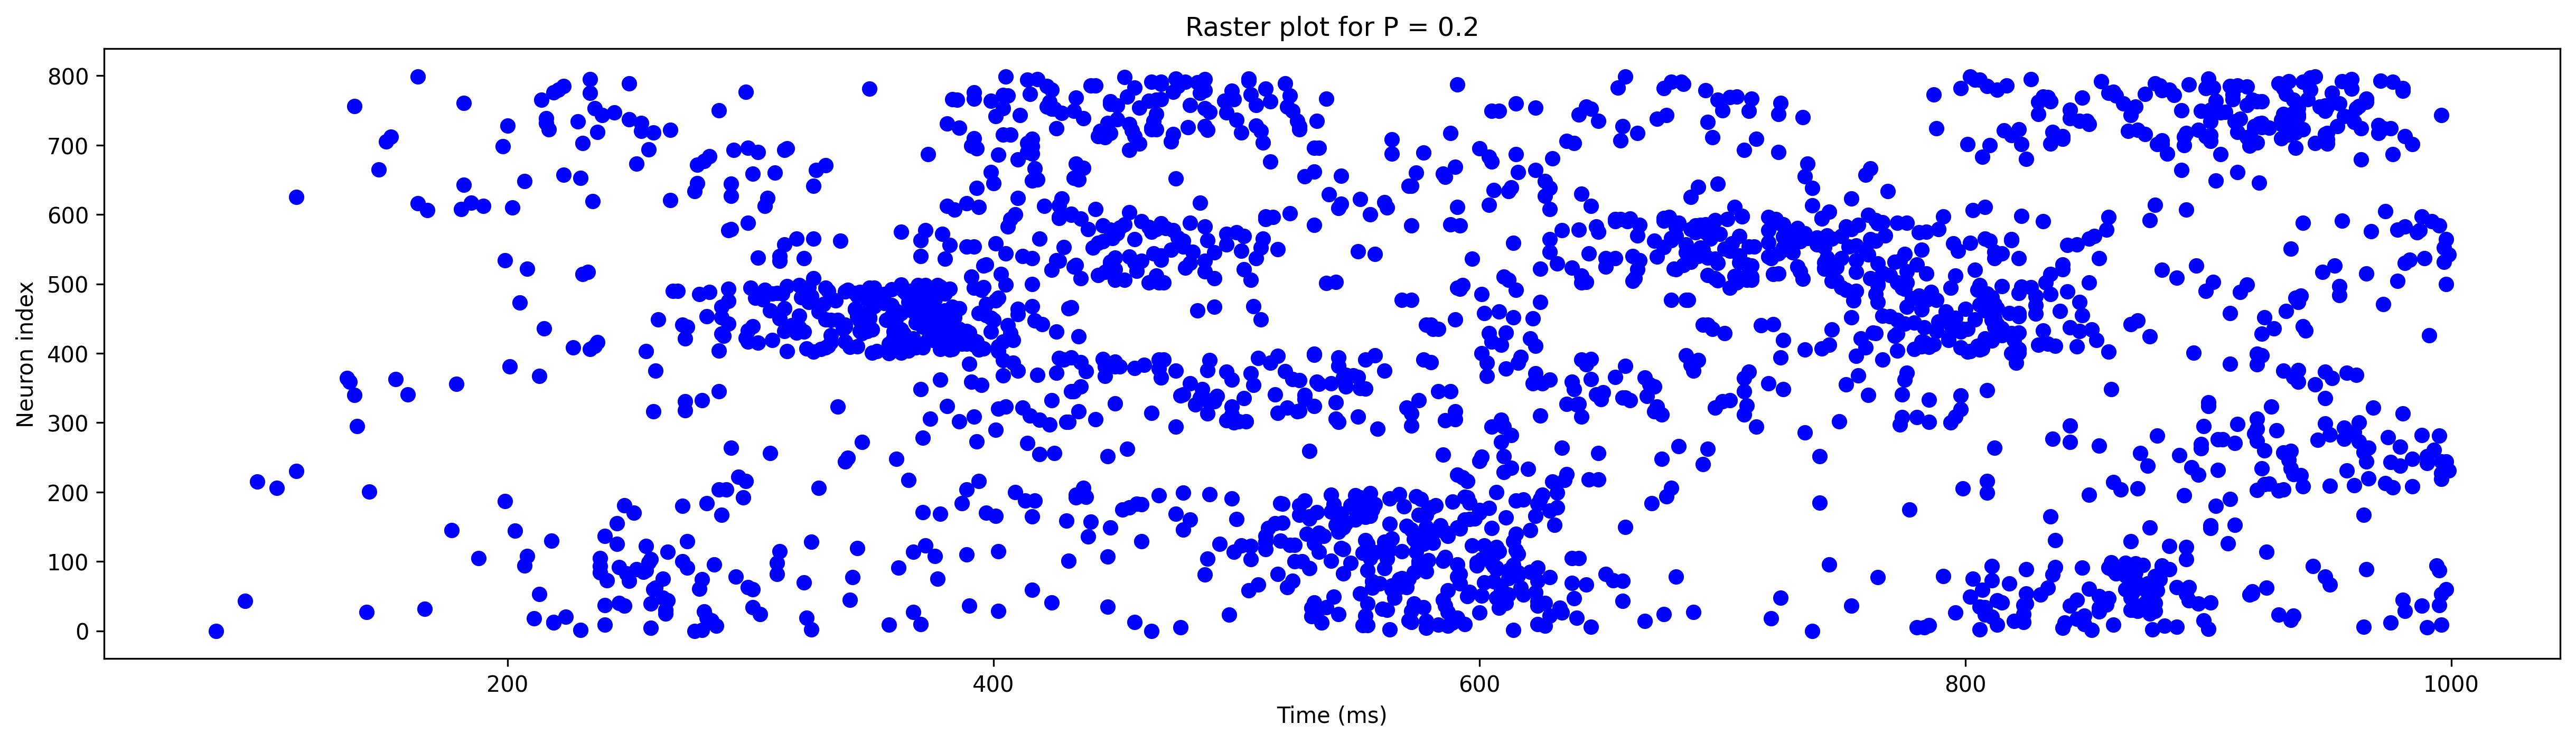

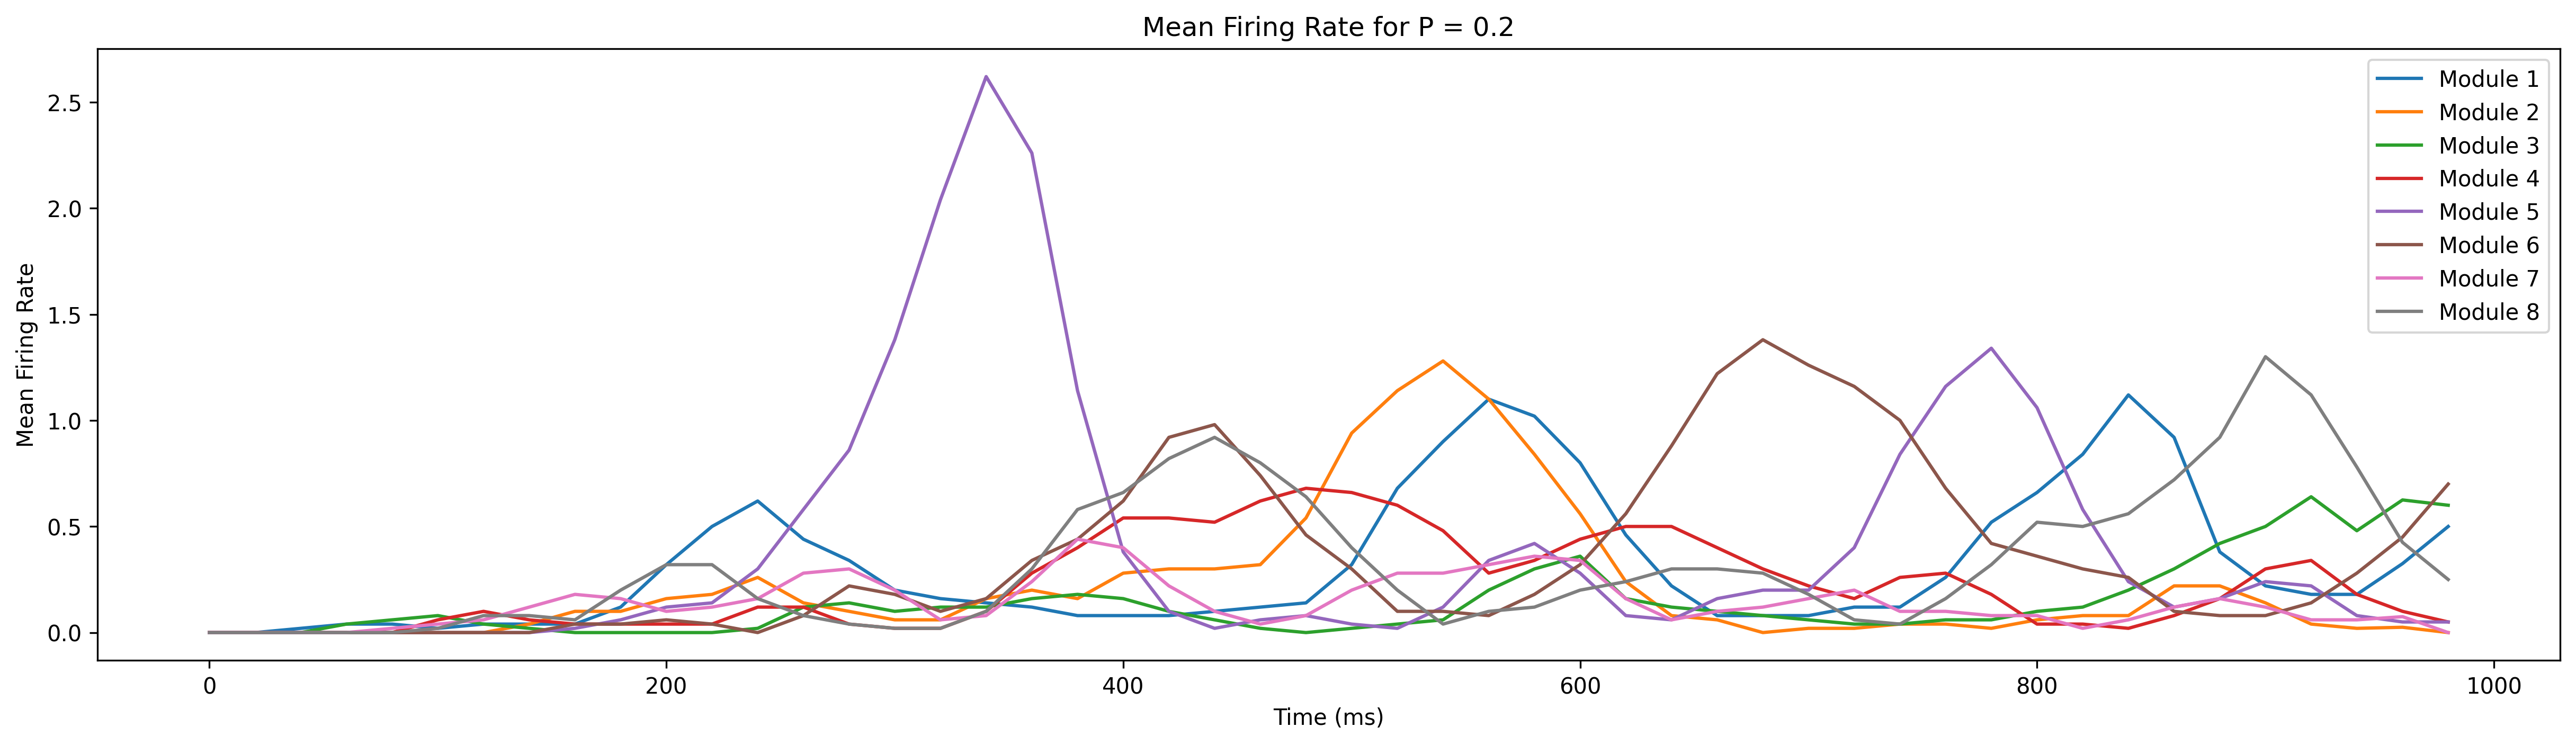

In [8]:
p = 0.2
network = Network(num_e_modules, num_i_modules, num_e_neurons, num_i_neurons, p)
network.initial_setup()
network.rewiring()
network.configure_iznetwork()
V = np.zeros((T, network.N))
current = np.zeros((T, network.N))  # Initialize current for each neuron (assuming an array of currents for each time step)
# Simulate background firing for each neuron at each time step
for t in range(T):
    poisson_events = np.random.poisson(lambda_rate, network.N)
    current[t, poisson_events > 0] = extra_current
    network.i_network.setCurrent(current[t])
    network.i_network.update()
    V[t, :], _ = network.i_network.getState()

connection_matrix_plot(network, p)
raster_plot(V, p)
mean_firing_plot(V, p)

### P = 0.3

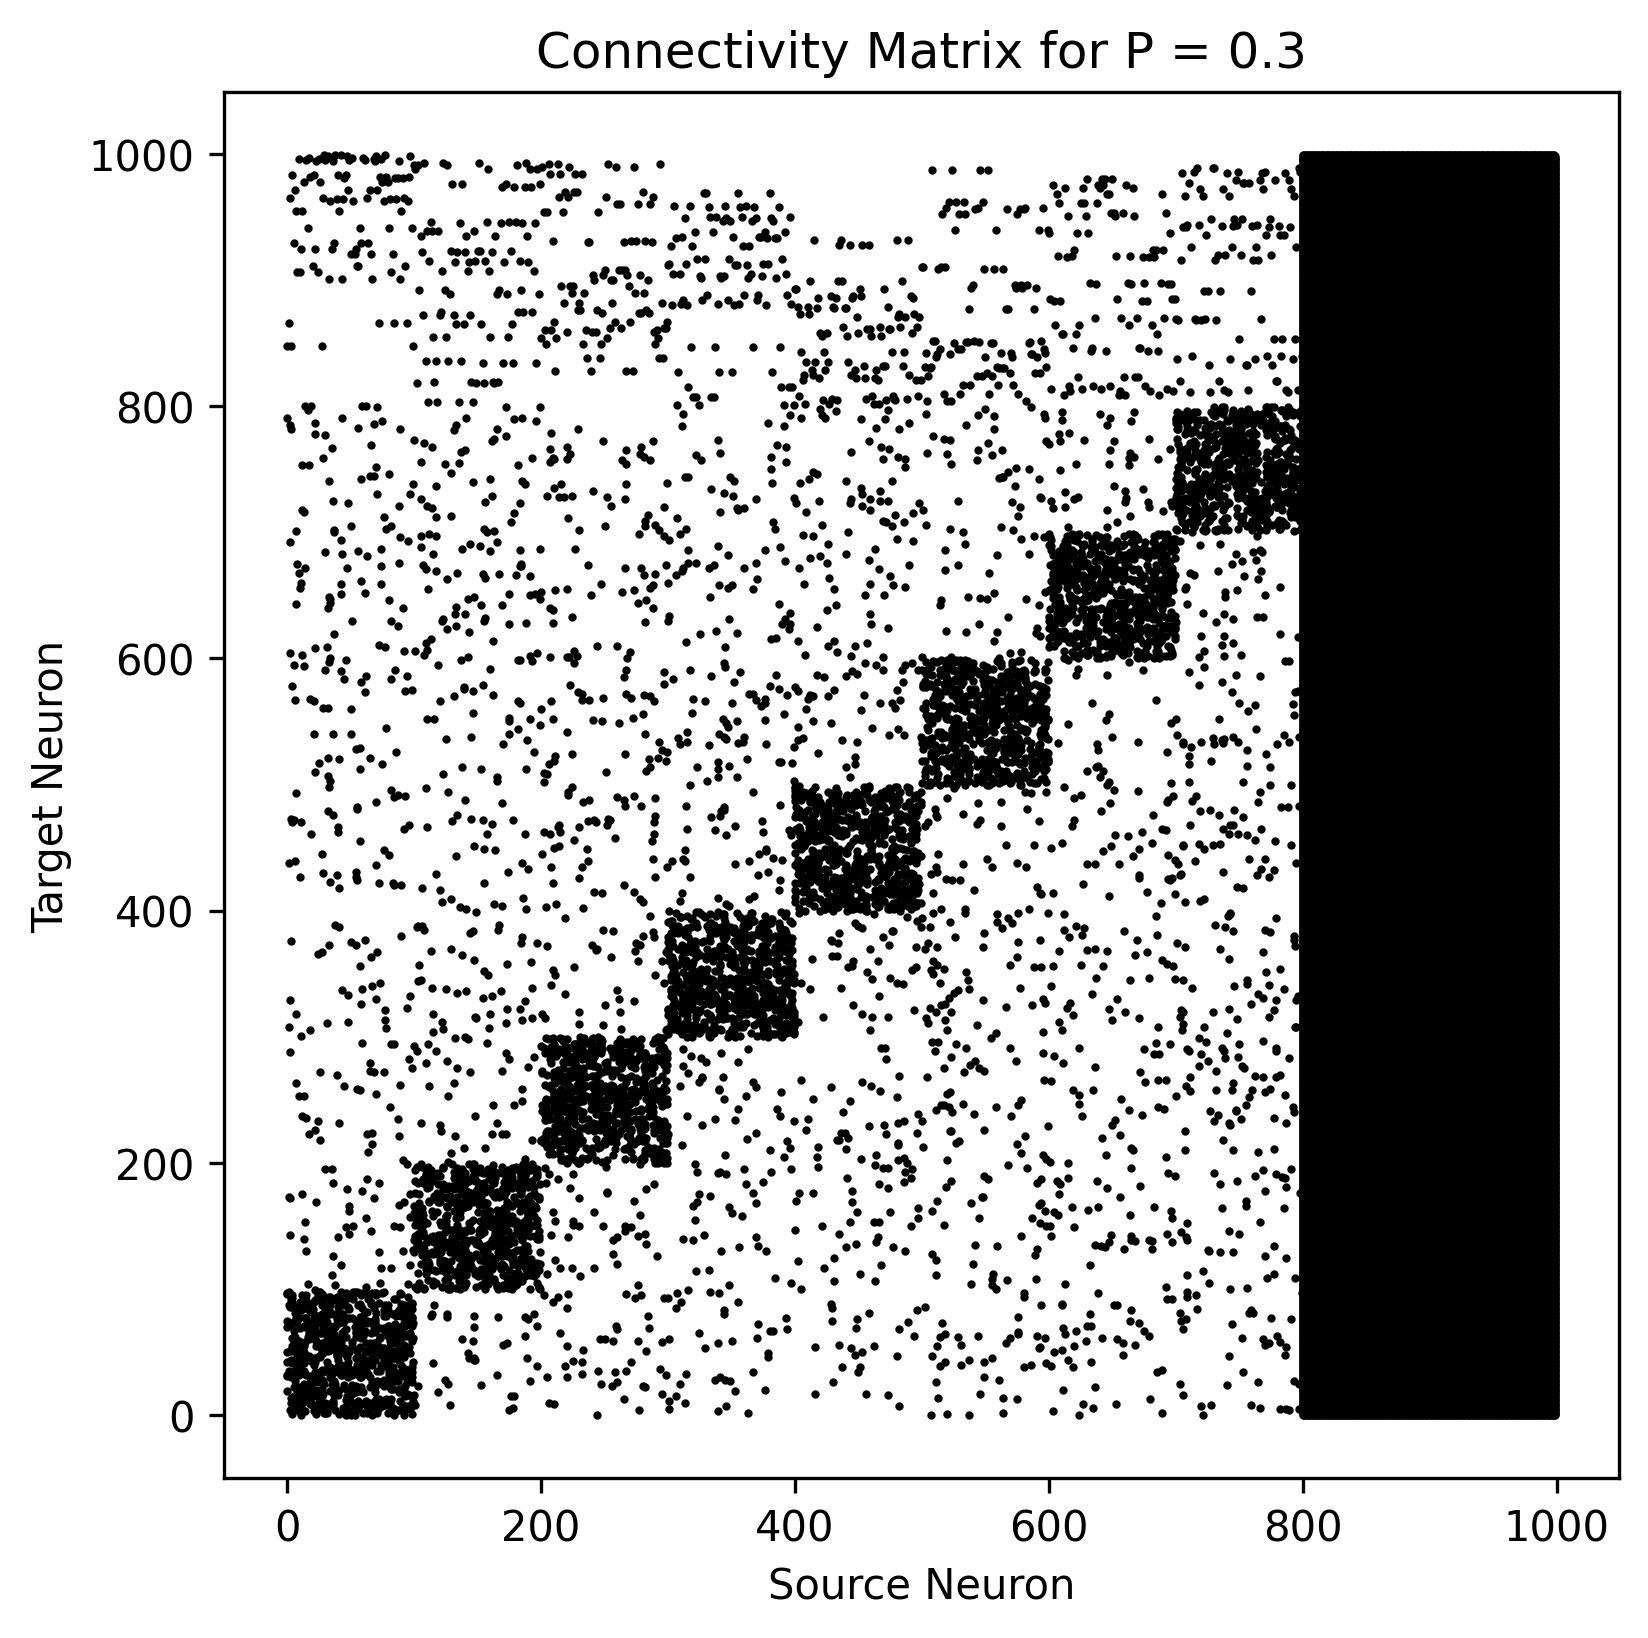

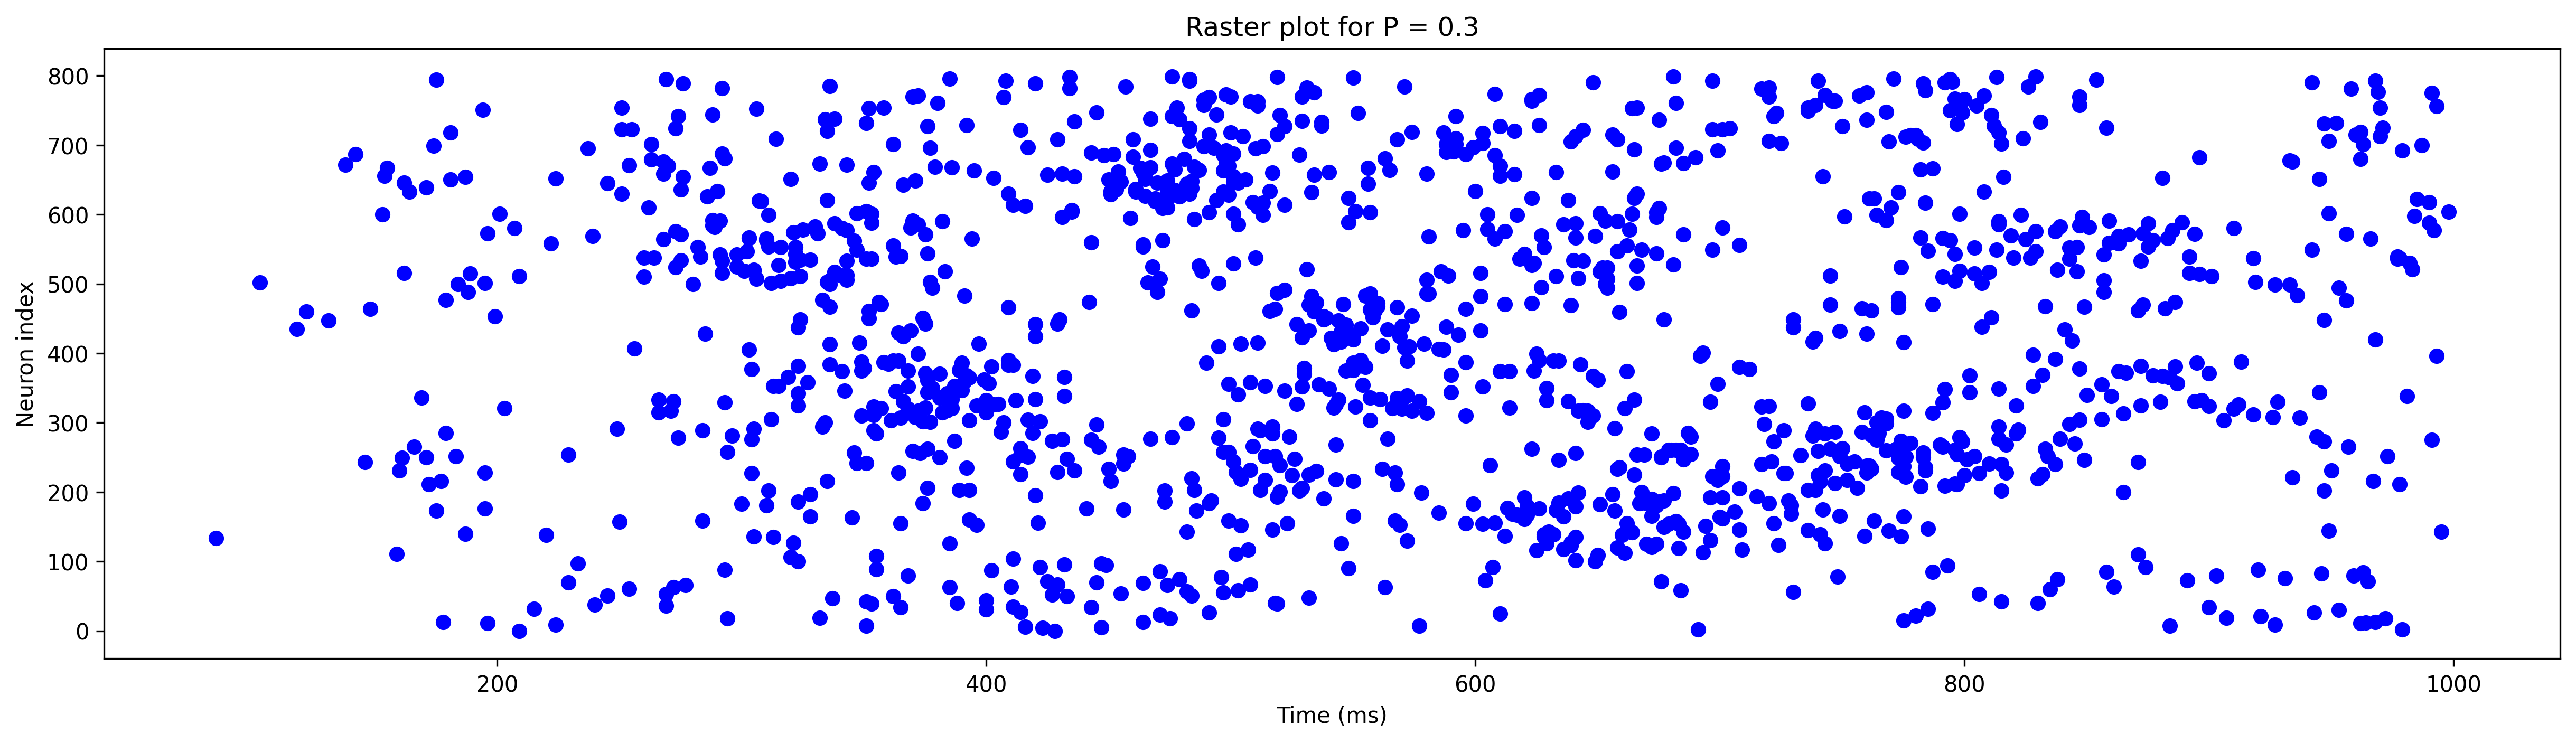

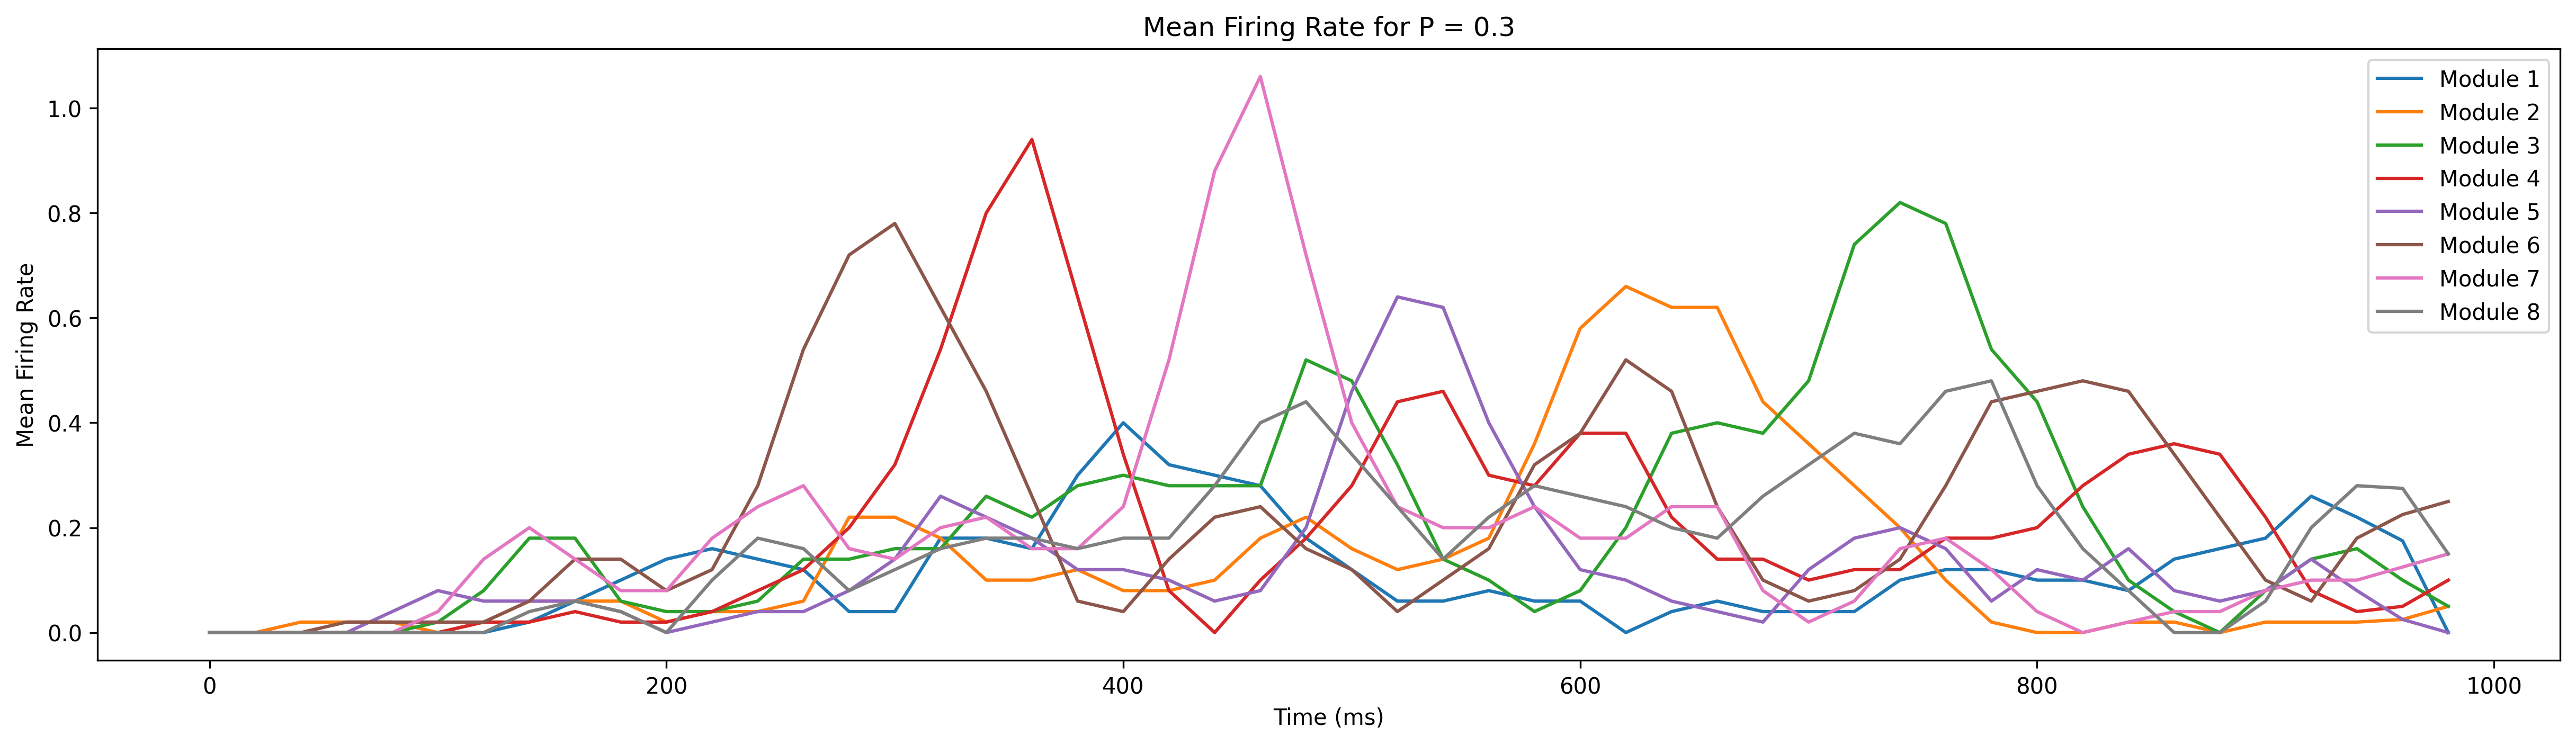

In [9]:
p = 0.3
network = Network(num_e_modules, num_i_modules, num_e_neurons, num_i_neurons, p)
network.initial_setup()
network.rewiring()
network.configure_iznetwork()
V = np.zeros((T, network.N))
current = np.zeros((T, network.N))  # Initialize current for each neuron (assuming an array of currents for each time step)
# Simulate background firing for each neuron at each time step
for t in range(T):
    poisson_events = np.random.poisson(lambda_rate, network.N)
    current[t, poisson_events > 0] = extra_current
    network.i_network.setCurrent(current[t])
    network.i_network.update()
    V[t, :], _ = network.i_network.getState()

connection_matrix_plot(network, p)
raster_plot(V, p)
mean_firing_plot(V, p)

### P = 0.4

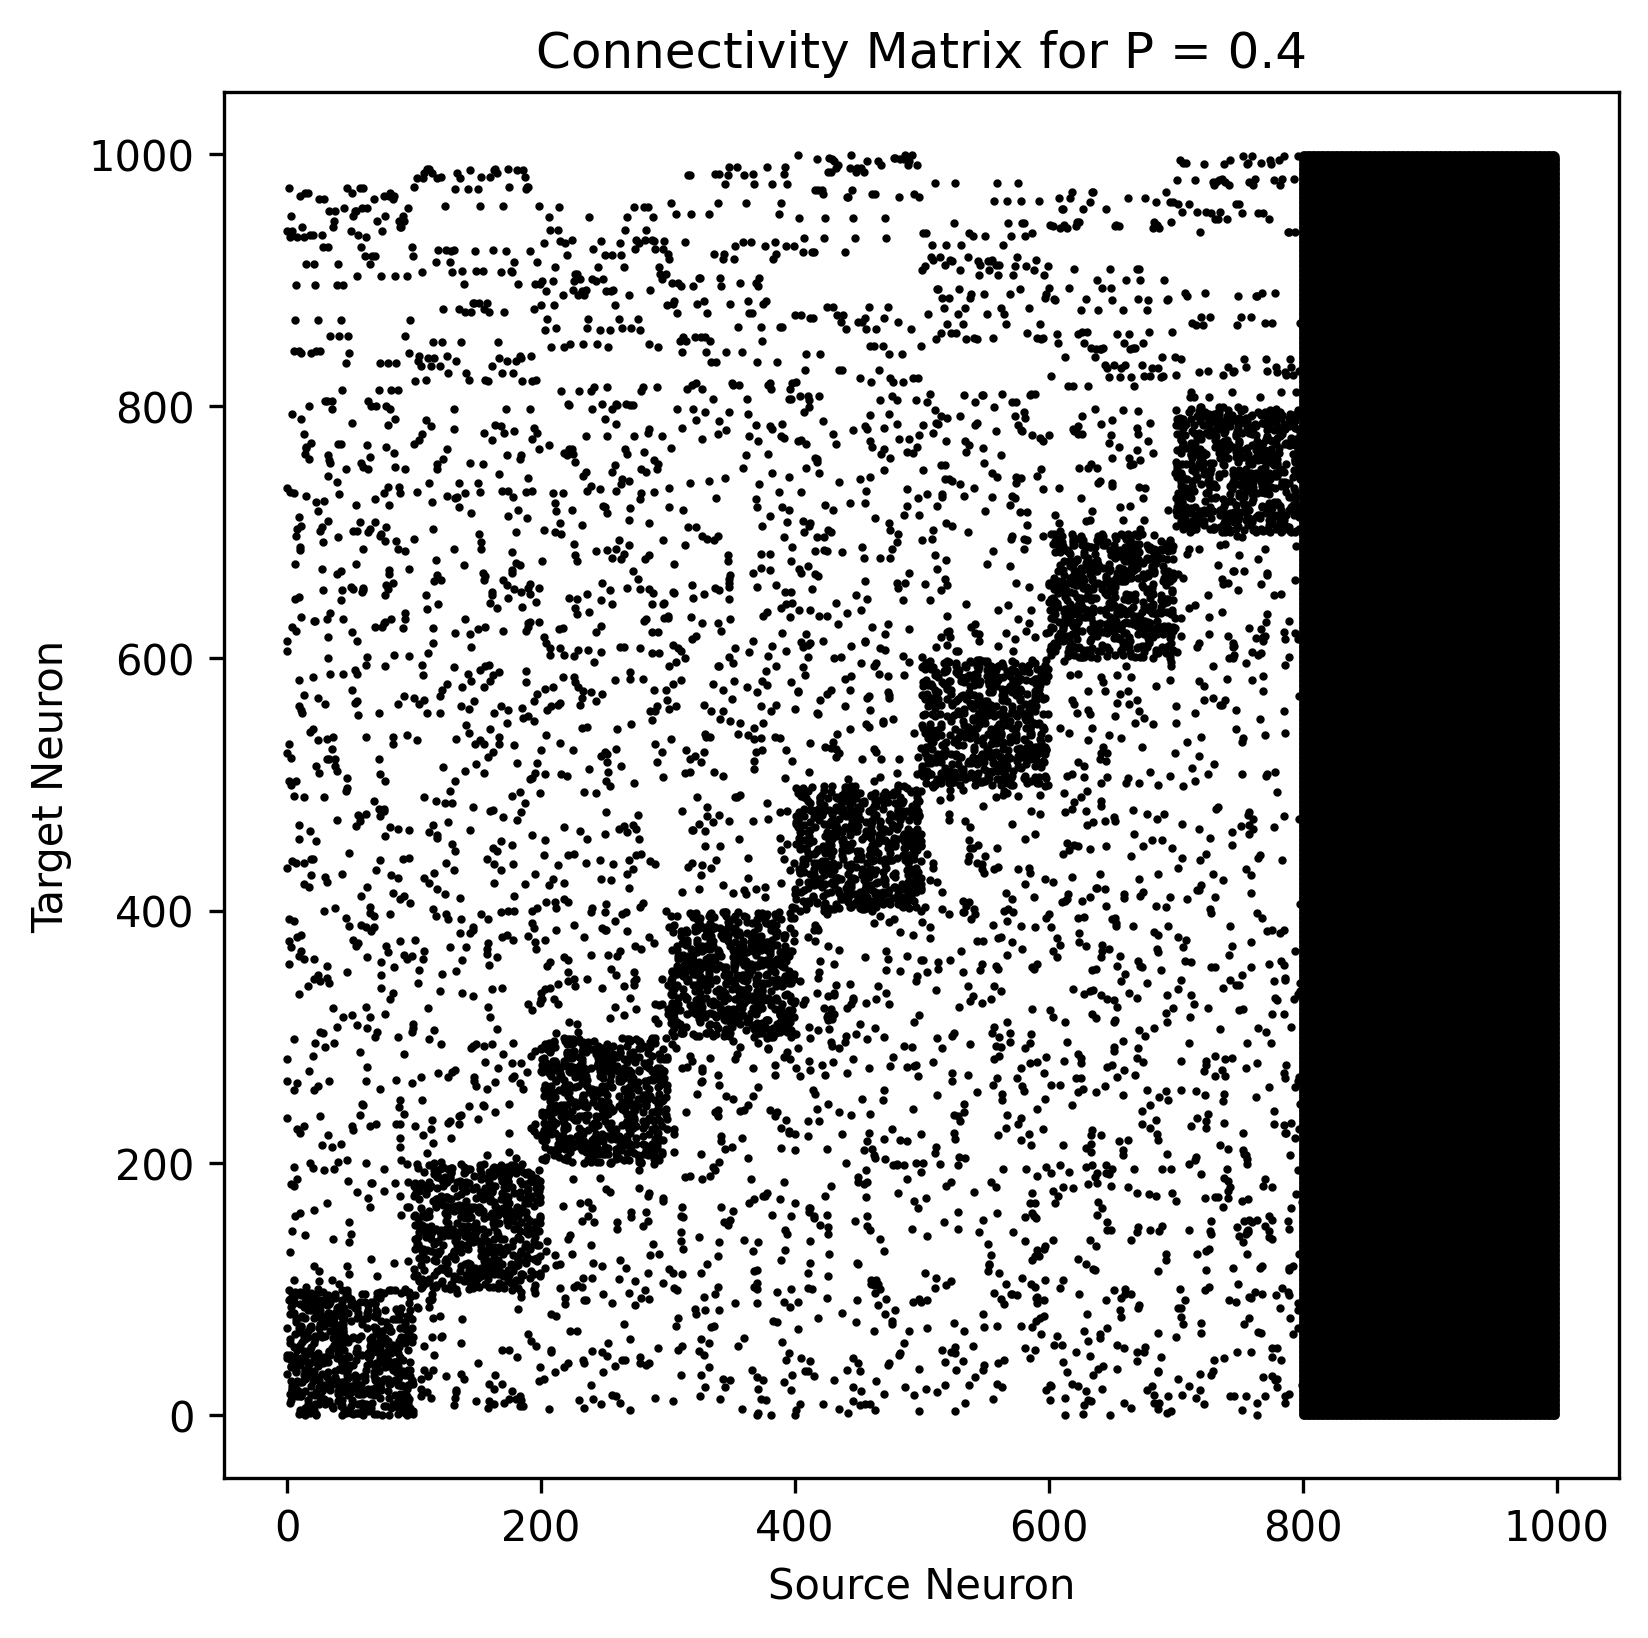

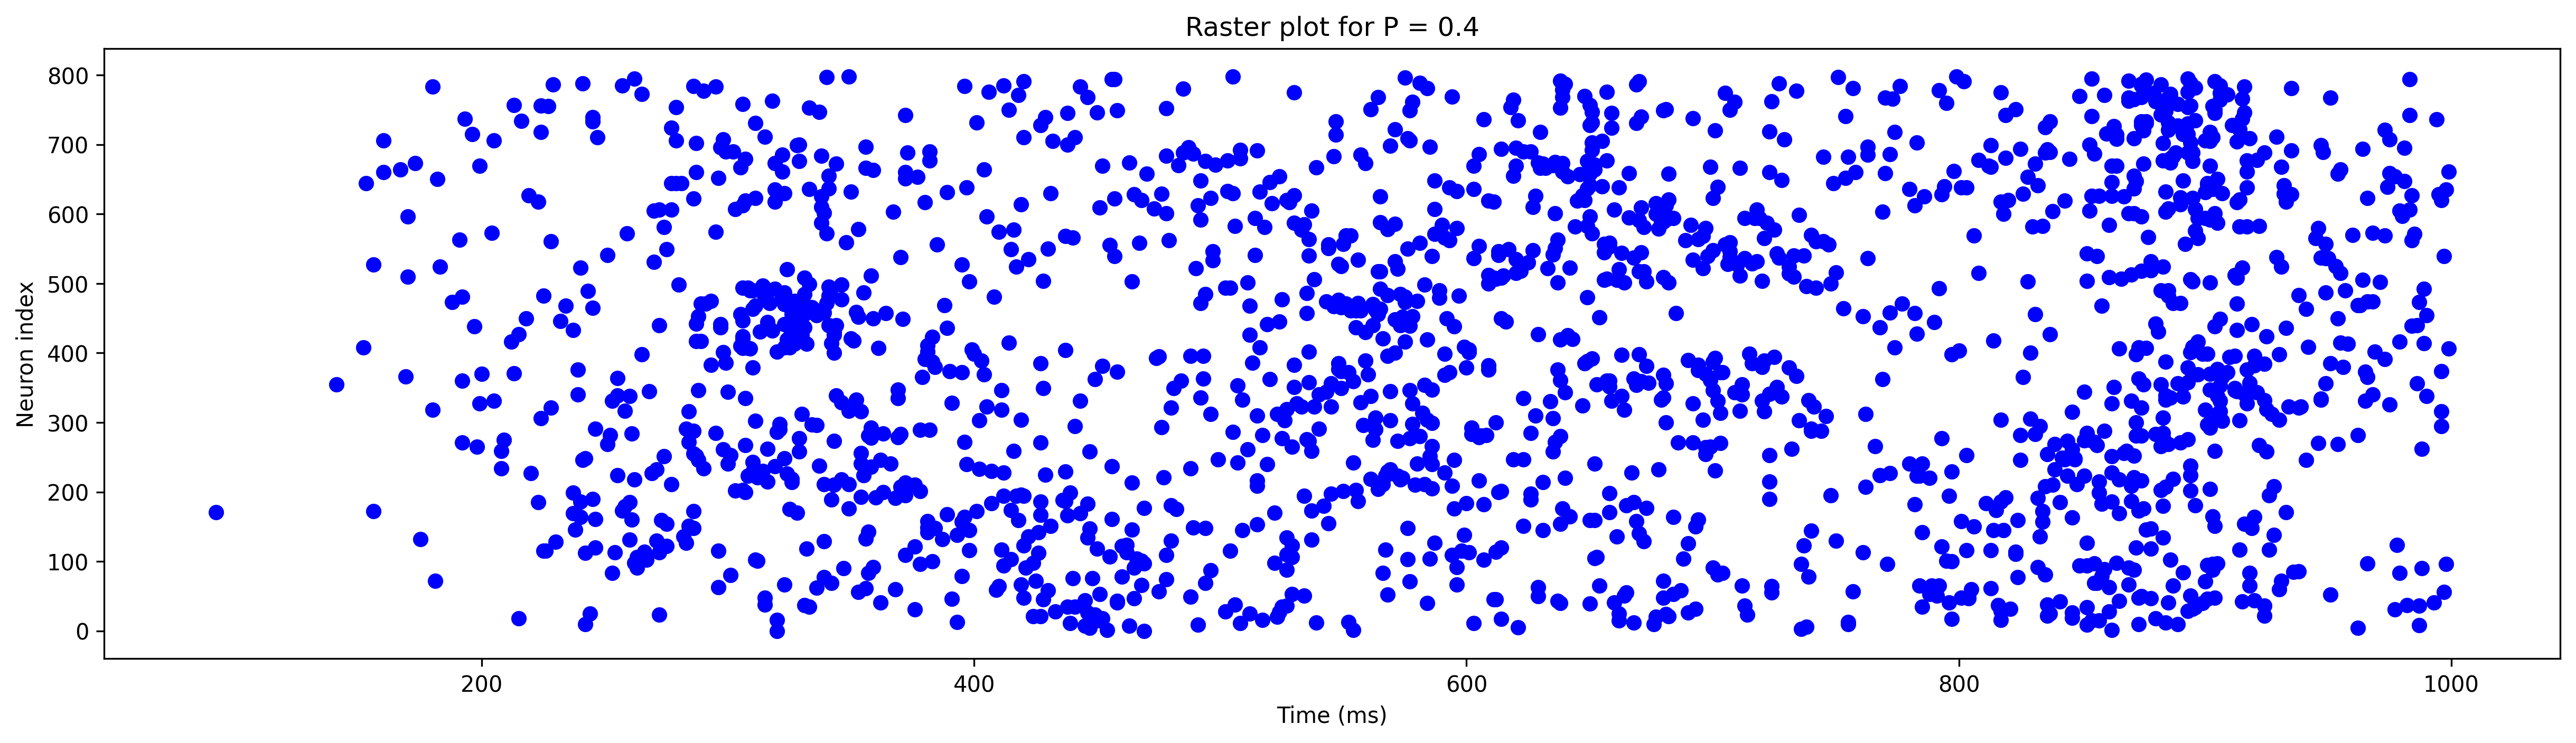

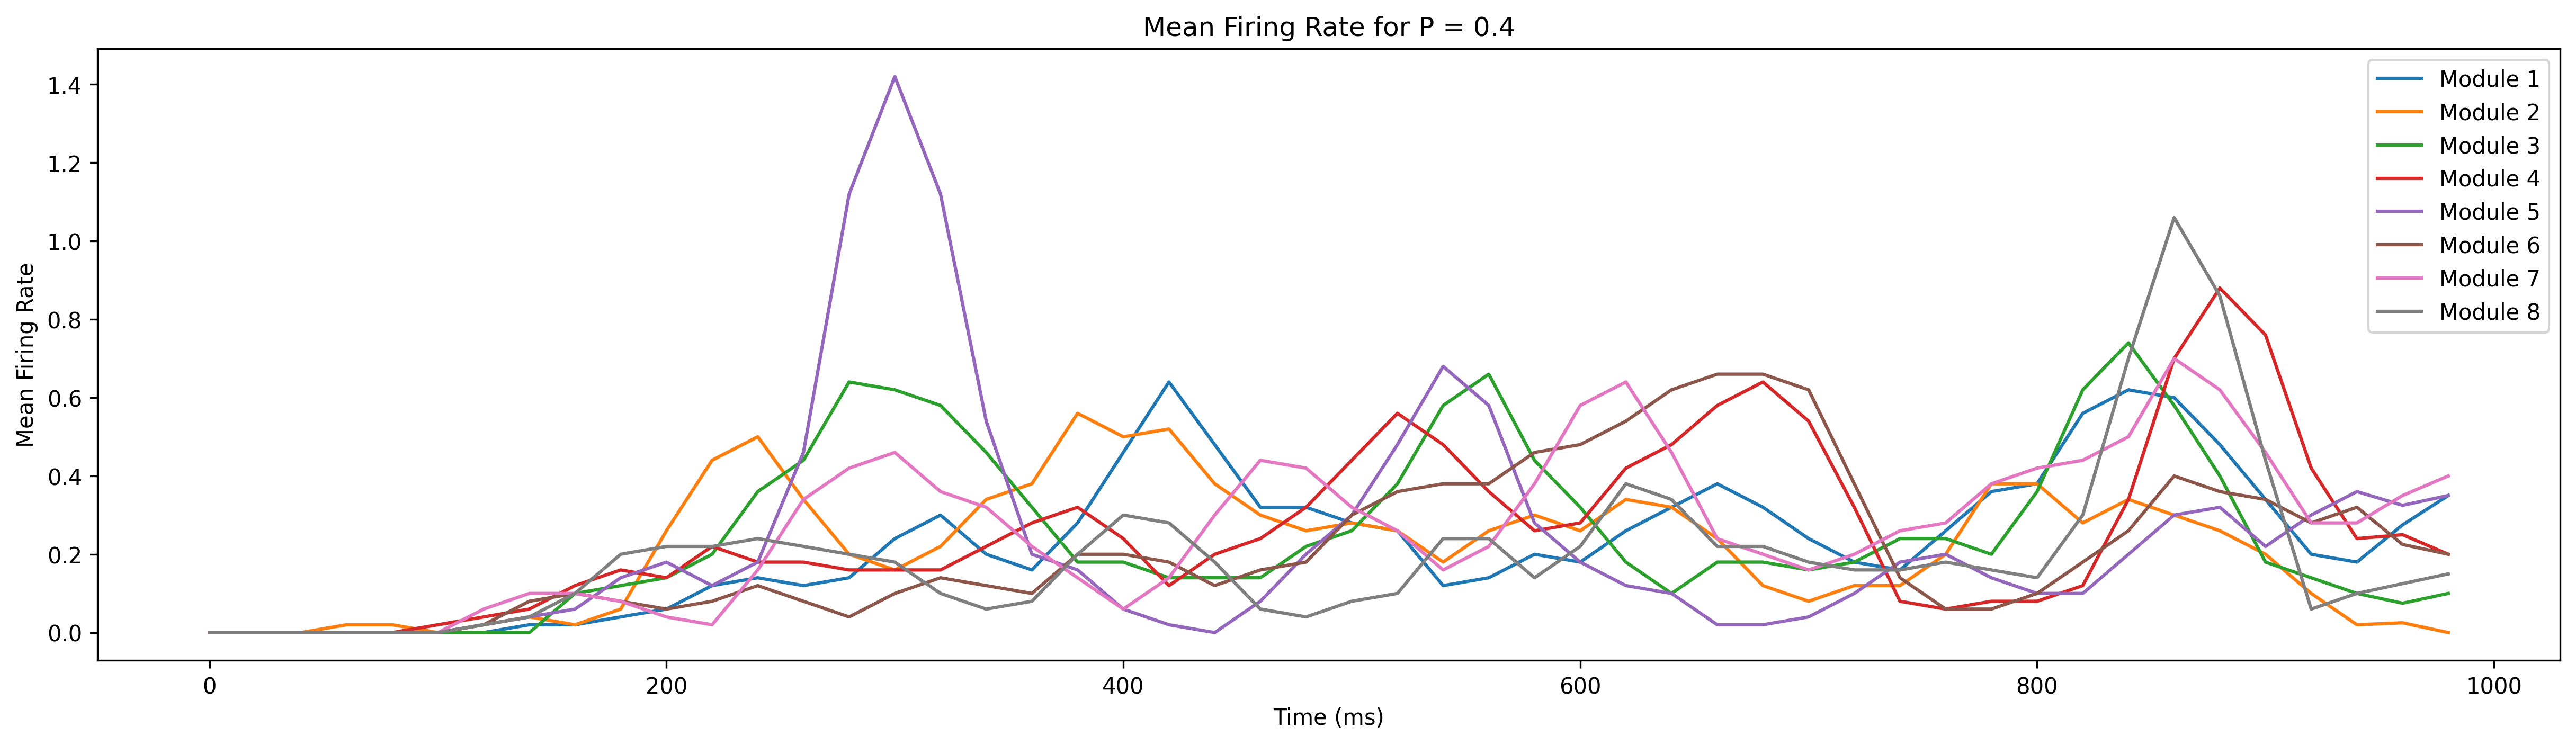

In [10]:
p = 0.4
network = Network(num_e_modules, num_i_modules, num_e_neurons, num_i_neurons, p)
network.initial_setup()
network.rewiring()
network.configure_iznetwork()
V = np.zeros((T, network.N))
current = np.zeros((T, network.N))  # Initialize current for each neuron (assuming an array of currents for each time step)
# Simulate background firing for each neuron at each time step
for t in range(T):
    poisson_events = np.random.poisson(lambda_rate, network.N)
    current[t, poisson_events > 0] = extra_current
    network.i_network.setCurrent(current[t])
    network.i_network.update()
    V[t, :], _ = network.i_network.getState()

connection_matrix_plot(network, p)
raster_plot(V, p)
mean_firing_plot(V, p)

### P = 0.5

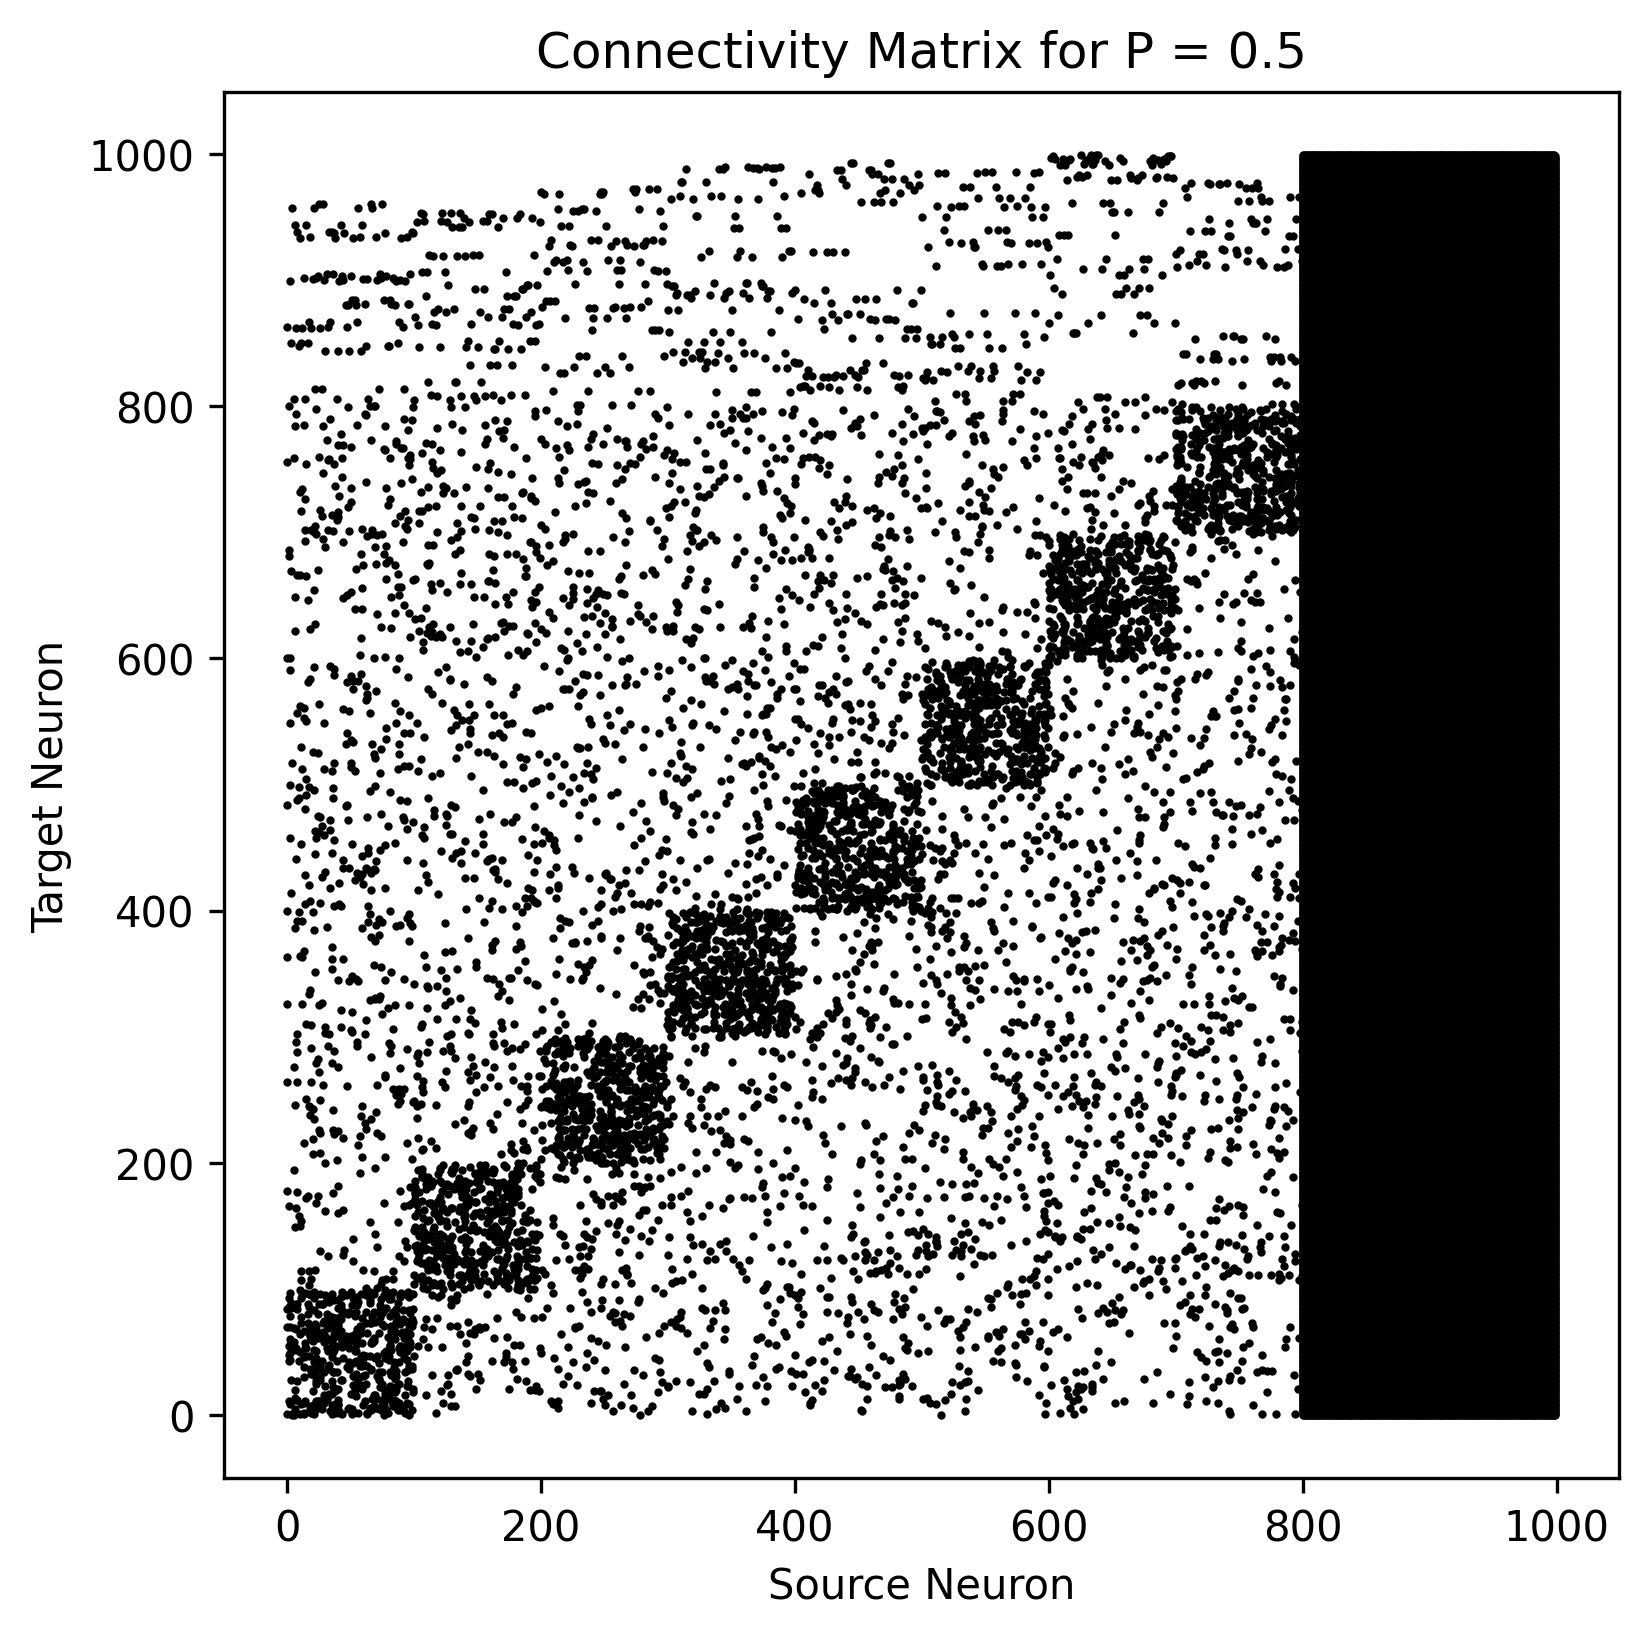

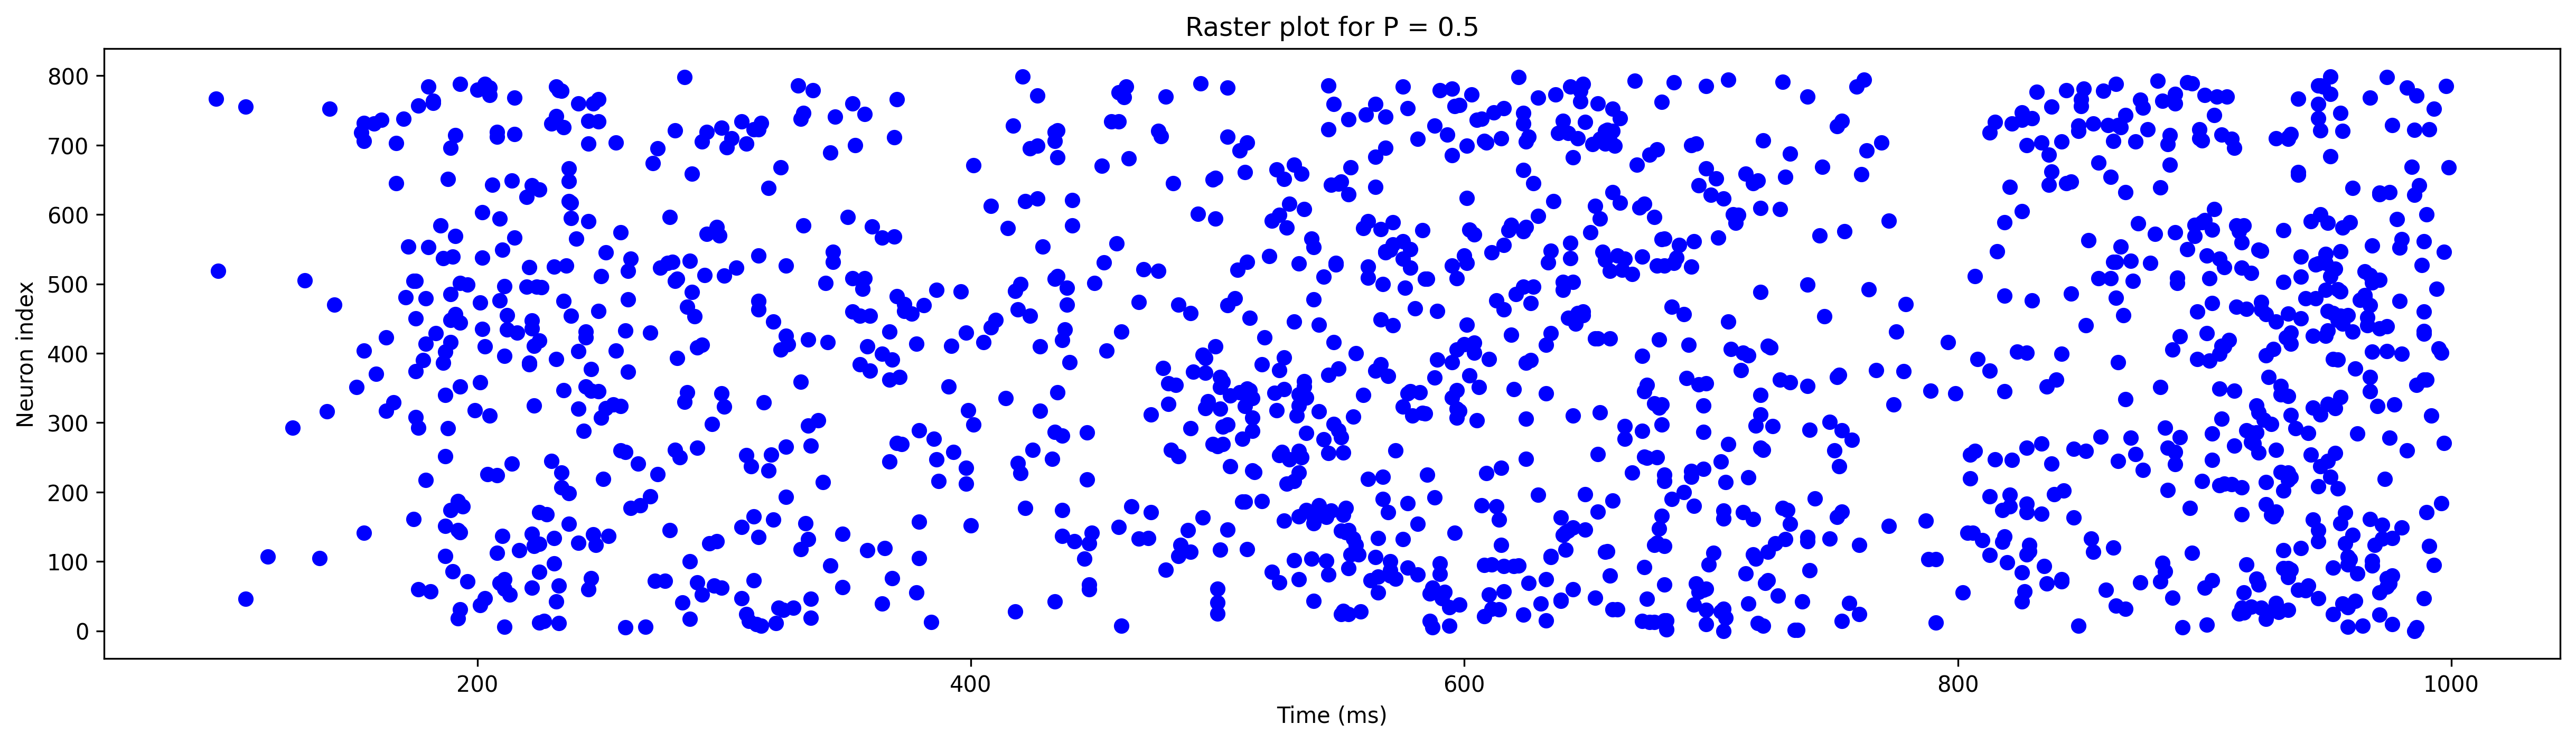

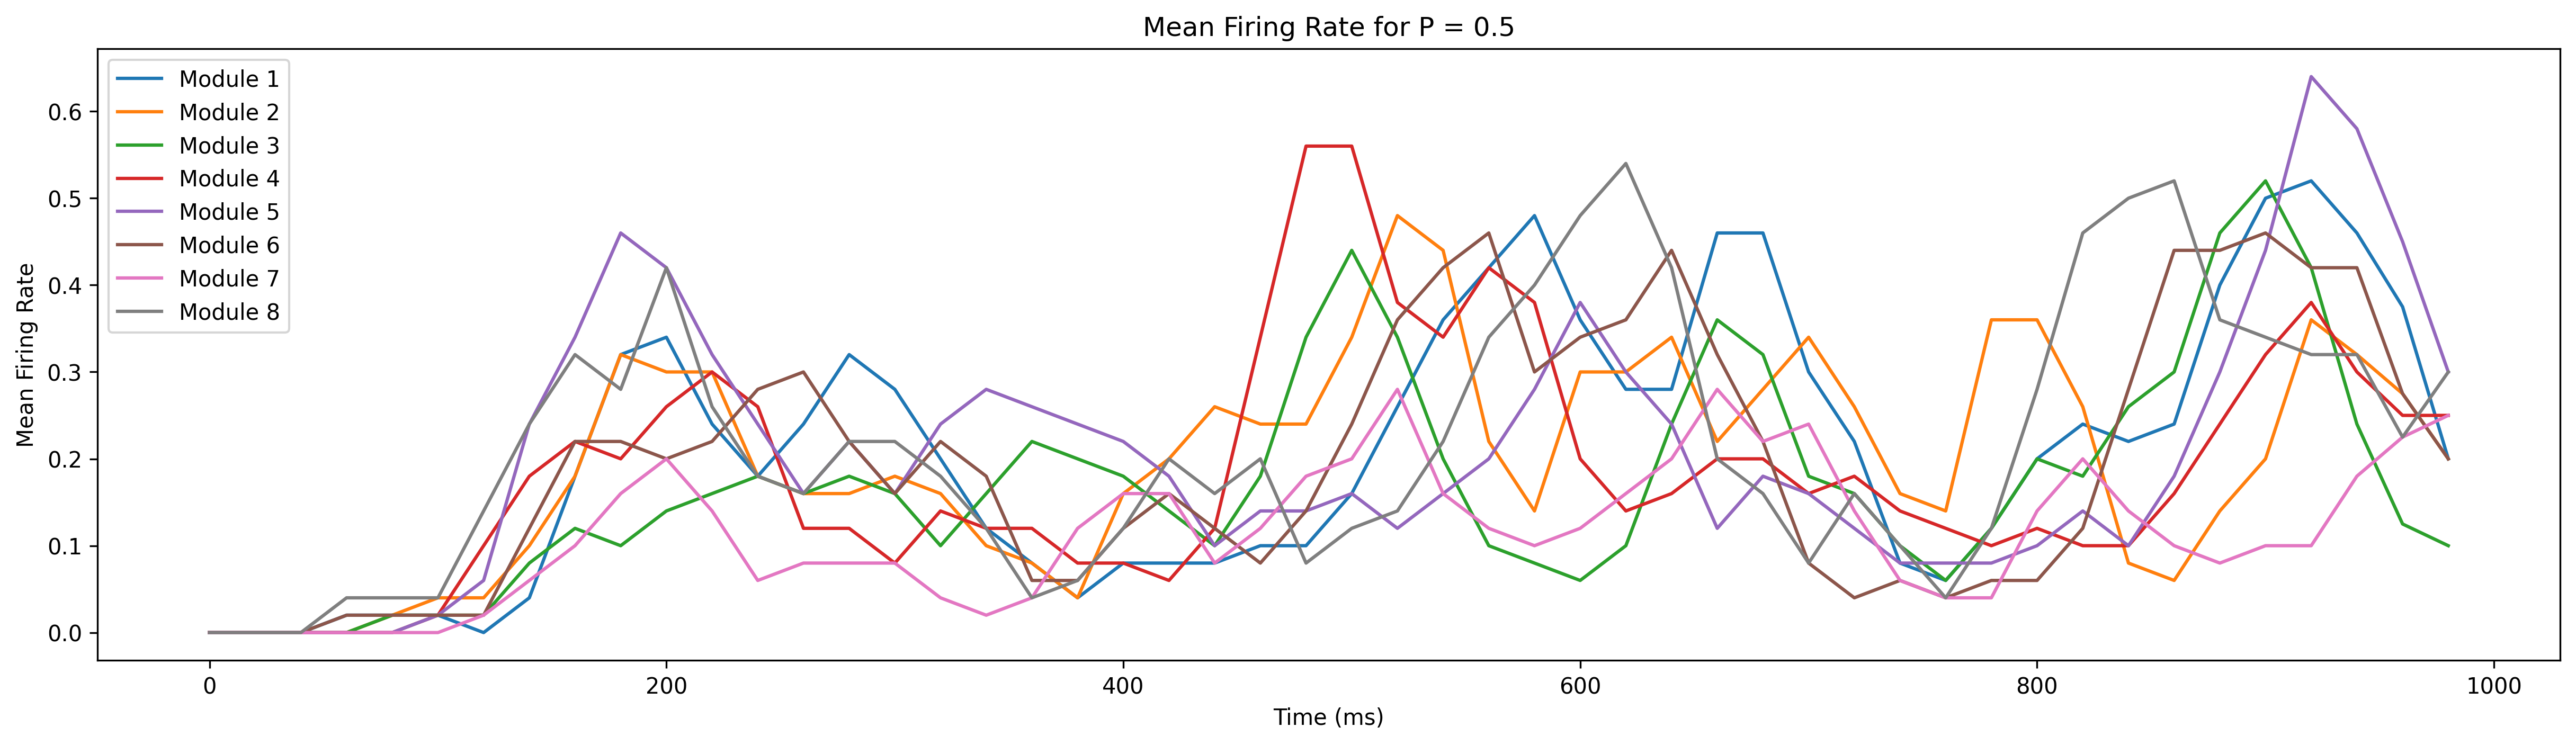

In [11]:
p = 0.5
network = Network(num_e_modules, num_i_modules, num_e_neurons, num_i_neurons, p)
network.initial_setup()
network.rewiring()
network.configure_iznetwork()
V = np.zeros((T, network.N))
current = np.zeros((T, network.N))  # Initialize current for each neuron (assuming an array of currents for each time step)
# Simulate background firing for each neuron at each time step
for t in range(T):
    poisson_events = np.random.poisson(lambda_rate, network.N)
    current[t, poisson_events > 0] = extra_current
    network.i_network.setCurrent(current[t])
    network.i_network.update()
    V[t, :], _ = network.i_network.getState()

connection_matrix_plot(network, p)
raster_plot(V, p)
mean_firing_plot(V, p)